In [1]:
import pickle
import xgboost as xgb
import pandas as pd
import numpy as np
from sklearn.cross_validation import KFold, train_test_split
from sklearn.metrics import confusion_matrix, mean_squared_error
from sklearn.grid_search import GridSearchCV
from sklearn.datasets import load_iris, load_digits, load_boston
%matplotlib inline
import seaborn as sns
from sklearn.metrics import r2_score, mean_squared_error, make_scorer
from collections import OrderedDict
import gc
from sklearn import datasets, linear_model,preprocessing
from IPython.display import display, HTML
import time
import nltk.corpus
from nltk.stem.snowball import SnowballStemmer

def RMSE(y_true,y_pred):
    mse = np.sqrt(mean_squared_error(y_true, y_pred))
    print 'MSE: %2.3f' % mse
    return mse

#take 1 CSV, then split it to 3..
class FeatureEngineering:

    def __init__(self, ValidationStart, ValidationEnd, trainHdfPath, trainHdfFile, testHdfPath1, testHdfPath2, testHdfFile, 
                 testTypes, trainTypes, trainCsvPath, testCsvPath, maxLag=0):
        self.ValidationStart = ValidationStart
        self.ValidationEnd = ValidationEnd
        self.maxLag = maxLag
        self.trainHdfPath = trainHdfPath
        self.trainHdfFile = trainHdfFile
        self.testHdfPath1 = testHdfPath1
        self.testHdfPath2 = testHdfPath2
        self.testHdfFile = testHdfFile
        self.testTypes = testTypes
        self.trainTypes = trainTypes
        self.trainCsvPath = trainCsvPath
        self.testCsvPath = testCsvPath
        
    @staticmethod
    def __printDataFrameBasics__(data):
        display(data.head(2))
        #print data.dtypes
        gc.collect()
        print(data.info(memory_usage=True))
        
    @staticmethod    
    def changeIndexTypeToLowerMemory(data):
        ##########
        #This is very critical, i accept max number is 2^32. Also, if don't do that, memory gets so much higher..
        ##########
        #data.reset_index(inplace=True)
        #data.drop("index",axis=1, inplace=True)
        #data.index = data.index.astype('uint32')
        gc.collect()
        
    def ReadHdf(self, trainOrTestOrBoth):
        '''Reads and holds Df in object memory'''            
        if trainOrTestOrBoth == 'train' or trainOrTestOrBoth=='both':
            self.train = pd.read_hdf(self.trainHdfPath,self.trainHdfFile)
            FeatureEngineering.changeIndexTypeToLowerMemory(self.train)
            FeatureEngineering.__printDataFrameBasics__(self.train)
            
        if trainOrTestOrBoth == 'test' or trainOrTestOrBoth=='both':
            self.test1 = pd.read_hdf(self.testHdfPath1,self.testHdfFile)
            self.test2 = pd.read_hdf(self.testHdfPath2,self.testHdfFile)
            FeatureEngineering.changeIndexTypeToLowerMemory(self.test1)
            FeatureEngineering.changeIndexTypeToLowerMemory(self.test2)
            FeatureEngineering.__printDataFrameBasics__(self.test1)
            FeatureEngineering.__printDataFrameBasics__(self.test2)
        
    def ReadCsv(self, trainOrTestOrBoth):
        '''Reads and holds Df in memory'''
        if trainOrTestOrBoth == 'train' or trainOrTestOrBoth == 'both':
            self.train = pd.read_csv(self.trainCsvPath, usecols=self.trainTypes.keys(), dtype=self.trainTypes)
            FeatureEngineering.changeIndexTypeToLowerMemory(self.train)
            FeatureEngineering.__printDataFrameBasics__(self.train)
        if trainOrTestOrBoth == 'test' or trainOrTestOrBoth=='both':
            tempTest = pd.read_csv(self.testCsvPath, usecols=self.testTypes.keys(), dtype=self.testTypes)
            self.test1 = tempTest.loc[tempTest.Semana.values == self.ValidationStart]
            self.test2 = tempTest.loc[tempTest.Semana.values == self.ValidationEnd]
            del tempTest
            FeatureEngineering.changeIndexTypeToLowerMemory(self.test1)
            FeatureEngineering.changeIndexTypeToLowerMemory(self.test2)
            FeatureEngineering.__printDataFrameBasics__(self.test1)
            FeatureEngineering.__printDataFrameBasics__(self.test2)
            
    @staticmethod
    def ConvertCsvToHdf(csvPath, HdfPath, HdfName, ColumnTypeDict ):
        tempDf = pd.read_csv(csvPath, usecols=ColumnTypeDict.keys(), dtype=ColumnTypeDict,index=False)
        tempDf.to_hdf(HdfPath, HdfName, format='t')
        del tempDf
        gc.collect()
        print "ConvertCsvToHdf is done.."

    def Preprocess(self, trainOrTestOrBoth, columnFunctionTypeList):
        '''columnFunctionTypeList = [ ['C1',Func1,Type], ['C2',Func2,Type],..    ]'''
        for column, func, localType in columnFunctionTypeList:
            if trainOrTestOrBoth == 'train' or trainOrTestOrBoth =='both':
                self.train.loc[:,column] =  np.apply_along_axis(func,0,FE.train[column].values).astype(localType)
                #np.apply_along_axis(lambda x: x+1,0,FE.train["Semana"]).astype("int32")
            if trainOrTestOrBoth == 'test' or trainOrTestOrBoth == 'both':
                self.test1.loc[:,column] =  np.apply_along_axis(func,0,FE.test1[column].values).astype(localType)
                self.test2.loc[:,column] =  np.apply_along_axis(func,0,FE.test2[column].values).astype(localType)
        gc.collect()
        
    def SaveDataFrameToHdf(self,trainOrTestOrBoth):
        if trainOrTestOrBoth == 'train' or trainOrTestOrBoth=='both':
            self.train.to_hdf(self.trainHdfPath, self.trainHdfFile, format='t', index="False")
        if trainOrTestOrBoth == 'test' or trainOrTestOrBoth=='both':
            self.test1.to_hdf(self.testHdfPath1, self.testHdfFile, format='t', index="False")
            self.test2.to_hdf(self.testHdfPath2, self.testHdfFile, format='t', index="False")
        
    def AddDemandaGeneralMean(self,trainOrTestOrBoth): 
        #self.train.loc[:,"DemandaGeneralMean"] = self.train["Demanda_uni_equil"].loc[
         #   self.train.loc[:,'Semana'] < 10].mean().astype("float32")
            
        meanOfDemanda = self.train["Demanda_uni_equil"].values.mean().astype("float32")
        
        if trainOrTestOrBoth == 'train' or trainOrTestOrBoth=='both':
            self.train.loc[:,"DemandaGeneralMean"] = meanOfDemanda
        if trainOrTestOrBoth == 'test' or trainOrTestOrBoth=='both':
            self.test1.loc[:,"DemandaGeneralMean"] = meanOfDemanda
            self.test2.loc[:,"DemandaGeneralMean"] = meanOfDemanda
        
        #self.train.loc[:,"DemandaGeneralMean"] = self.train["Demanda_uni_equil"].values[
        #(self.train.loc[:,'Semana'].values < self.ValidationStart).values].mean().astype("float32")
        gc.collect()
        
    '''ConfigElements(0,[ ("A",["Semana","Agencia_ID"],["count","count"]),'''
    def AddConfigurableFeaturesToTrain(self, config):
        if config.lag > self.maxLag:
            self.maxLag = config.lag
        
        tempData = self.train[self.train['Semana'].values <= (self.ValidationEnd - config.lag)]
        #display(tempData)
        if(config.lag != 0):
            tempData.loc[:,'Semana'] = tempData['Semana'].values + config.lag
        #display(tempData)
        
        #Means iterative.. eliminate as long as np.nan exists..If there is already one, don't create, use the existing
        if config.targetVariable != "" and  config.targetVariable not in self.train.columns:
            self.train.loc[:,config.targetVariable] = np.nan
            self.test1.loc[:,config.targetVariable] = np.nan
            
            if config.lag != 1:
                self.test2.loc[:,config.targetVariable] = np.nan
        
        for name,groups,aggregate in config.nameAndGroups:
            if name not in self.train.columns:
                print "{} is not in columns..".format(name)            
                
                groupedDataframe = tempData[groups+['Demanda_uni_equil']].copy().groupby(groups).agg(aggregate[0])
                gc.collect()
                #groupedDataframe.columns = groupedDataframe.columns.droplevel(0)
                groupedDataframe.columns = [name]
                
                #This is means of the counts of the semana-columns tuples!..!!!
                #If no lag and mean, mean of the columns without semana!!..
                #If there is lag and count, count of the columns x weeks before
                #If there is lag and mean, mean of the columns x weeks before
                #if(config.lag == 0 and aggregate == "count"):
                if(len(aggregate)>1):
                    groupedDataframe.reset_index(inplace=True)
                    groupedDataframe.drop("Semana",axis=1, inplace=True)
                    groups = groups[1:]
                    groupedDataframe = groupedDataframe.groupby(groups).agg(aggregate[1])
                    groupedDataframe.columns = [name]
                    gc.collect()
                
                display(groupedDataframe)
                self.train = self.train.merge( groupedDataframe, left_on=groups,
                    right_index=True, how='left', sort=False,copy=False)
                gc.collect()
                self.test1 = self.test1.merge( groupedDataframe, left_on=groups,
                    right_index=True, how='left', sort=False,copy=False)
                gc.collect()
                if config.lag != 1:
                    self.test2 = self.test2.merge( groupedDataframe, left_on=groups,
                        right_index=True, how='left', sort=False,copy=False)
                
                del groupedDataframe
                gc.collect()
            else:
                print "{} is in columns..".format(name)
            
            display(self.train)
            display(self.test1)
            display(self.test2)
            
            #Means iterative..!!!!!
            if config.targetVariable != "":
                self.train.loc[pd.isnull(self.train[config.targetVariable].values), 
                    config.targetVariable] = self.train.loc[pd.isnull(self.train[config.targetVariable].values)
                    , name].values
                self.test1.loc[pd.isnull(self.test1[config.targetVariable].values), 
                    config.targetVariable] = self.test1.loc[pd.isnull(self.test1[config.targetVariable].values),
                    name].values
                if config.lag != 1:
                    self.test2.loc[pd.isnull(self.test2[config.targetVariable].values), 
                        config.targetVariable] = self.test2.loc[pd.isnull(self.test2[config.targetVariable].values)
                        , name].values
                    
                count = self.test1[config.targetVariable].isnull().sum()
                print "Count of missing numbers after {} in validation part 1 in column {} is {}".format(name, 
                    config.targetVariable,str(count))
                if config.lag != 1:
                    count = self.test2.loc[:,config.targetVariable].isnull().sum()
                    print "Count of missing numbers after {} in validation part 2 in column {} is {}".format(name, 
                        config.targetVariable,str(count))
                
                
                #display(self.train)
                #If column is already in Dataframe and we want to fill target variable, this deletes columns!!!
                if(config.deleteColumns):
                    self.train.drop(name, axis=1, inplace=True)
                    self.test1.drop(name, axis=1, inplace=True)
                    if config.lag != 1:
                        self.test2.drop(name, axis=1, inplace=True)
                gc.collect()
                #Only in tesst
                #if count == 0:
                 #   break
        del tempData
        display(self.train)   
        display(self.test1)   
        display(self.test2)
        gc.collect()
        return 
    
    def DeleteLaggedWeeksFromTrain(self):
        self.train = self.train[self.train['Semana'].values >= (3 + self.maxLag)]
        gc.collect()
        display(self.train.head(2))
        
    def ReadFirstNRowsOfACsv(self, nrows, trainOrTestOrBoth) :
        if trainOrTestOrBoth == 'train' or trainOrTestOrBoth=='both':
            self.train = pd.read_csv(self.trainCsvPath, usecols=self.trainTypes.keys(), dtype=self.trainTypes, nrows = nrows)
            FeatureEngineering.changeIndexTypeToLowerMemory(self.train)
            FeatureEngineering.__printDataFrameBasics__(self.train)
        if trainOrTestOrBoth == 'test' or trainOrTestOrBoth=='both':
            tempTest = pd.read_csv(self.testCsvPath, usecols=self.testTypes.keys(), dtype=self.testTypes, nrows = nrows*2)
            self.test1 = tempTest.loc[tempTest.Semana == self.ValidationStart]
            self.test2 = tempTest.loc[tempTest.Semana == self.ValidationEnd]
            del tempTest
            FeatureEngineering.changeIndexTypeToLowerMemory(self.test1)
            FeatureEngineering.changeIndexTypeToLowerMemory(self.test2)
            FeatureEngineering.__printDataFrameBasics__(self.test1)
            FeatureEngineering.__printDataFrameBasics__(self.test2)
    
    #Use when concatanating train and validation before predict test for example..
    def AppendTestToTrain(self,deleteTest = True):
        self.train = self.train.append(self.test1,ignore_index=True)
        gc.collect()
        if(deleteTest):
            del self.test1
            gc.collect()
        try:
            self.train = self.train.append(self.test2,ignore_index=True)
            gc.collect()
            if(deleteTest):
                del self.test2
                gc.collect()
        except:
            pass
        #BAD PERFORMANCE!!
    #Split train data to train and test1 and test2 (validation)
    #def SplitTrainToTestUsingValidationStart(self):
     #   boolCondition = self.train.Semana == self.ValidationStart
      #  self.test1 = self.train.loc[boolCondition]
       # self.train.drop((self.train.loc[boolCondition].index), axis=0,inplace=True)
        
       # boolCondition = self.train.Semana == self.ValidationEnd
       # self.test2 = self.train.loc[boolCondition]
       # self.train.drop((self.train.loc[boolCondition].index), axis=0,inplace=True)
      #  del boolCondition
      #  gc.collect()
    
    #Reaches 3x memory from train, because of test1, test2 and train itself at the end.. GC fixed in the end..
    def SplitTrainToTestUsingValidationStart(self):
        boolCondition = self.train.Semana.values == self.ValidationStart
        self.test1 = self.train[boolCondition]
        boolCondition = self.train.Semana.values == self.ValidationEnd
        self.test2 = self.train[boolCondition]
        FE.train = FE.train[ FE.train.Semana.values < FE.ValidationStart ]
        del boolCondition
        gc.collect()
        
    def XgboostPredictAndSee(self, Test1OrTest2):
        self.train_y = self.train["Demanda_uni_equil"].copy()
        self.train.drop("Demanda_uni_equil",axis=1, inplace=True)
        

In [2]:
parameterDict =       {"ValidationStart":8, 
 "ValidationEnd":9,
   "maxLag":3,
    "trainHdfPath":'../../input/train_wz.h5',
    "trainHdfFile":"train",
    "testHdfPath1":"../../input/test1_wz.h5",
    "testHdfPath2":"../../input/test2_wz.h5",
    "testHdfFile":"test", 
    "trainTypes" : {'Semana':np.uint8, 'Agencia_ID':np.uint16, 'Canal_ID':np.uint8,'Ruta_SAK':np.uint16, 
        'Cliente_ID':np.uint32, 'Producto_ID':np.uint16,'Venta_uni_hoy':np.uint16, 'Venta_hoy':np.float32,
                    'Dev_uni_proxima': np.uint32, 'Dev_proxima':np.float32,'Demanda_uni_equil':np.uint32}, 
    "testTypes" : {'id':np.uint32,'Semana':np.uint8, 'Agencia_ID':np.uint16, 'Canal_ID':np.uint8,'Ruta_SAK':np.uint16,
        'Cliente_ID':np.uint32, 'Producto_ID':np.uint16},
    "trainCsvPath":'../../input/train.csv'   ,
    "testCsvPath":'../../input/test.csv'}

FE = FeatureEngineering(**parameterDict)
print FE.__dict__

{'trainCsvPath': '../../input/train.csv', 'maxLag': 3, 'testTypes': {'Cliente_ID': <type 'numpy.uint32'>, 'Ruta_SAK': <type 'numpy.uint16'>, 'Canal_ID': <type 'numpy.uint8'>, 'Producto_ID': <type 'numpy.uint16'>, 'Agencia_ID': <type 'numpy.uint16'>, 'Semana': <type 'numpy.uint8'>, 'id': <type 'numpy.uint32'>}, 'testHdfFile': 'test', 'trainTypes': {'Dev_proxima': <type 'numpy.float32'>, 'Venta_uni_hoy': <type 'numpy.uint16'>, 'Cliente_ID': <type 'numpy.uint32'>, 'Demanda_uni_equil': <type 'numpy.uint32'>, 'Ruta_SAK': <type 'numpy.uint16'>, 'Canal_ID': <type 'numpy.uint8'>, 'Venta_hoy': <type 'numpy.float32'>, 'Producto_ID': <type 'numpy.uint16'>, 'Agencia_ID': <type 'numpy.uint16'>, 'Dev_uni_proxima': <type 'numpy.uint32'>, 'Semana': <type 'numpy.uint8'>}, 'testHdfPath1': '../../input/test1_wz.h5', 'ValidationEnd': 9, 'testHdfPath2': '../../input/test2_wz.h5', 'testCsvPath': '../../input/test.csv', 'ValidationStart': 8, 'trainHdfFile': 'train', 'trainHdfPath': '../../input/train_wz.h5'}

In [3]:
FE.ReadHdf('both')

,Semana,Agencia_ID,Canal_ID,Ruta_SAK,Cliente_ID,Producto_ID,Venta_uni_hoy,Venta_hoy,Dev_uni_proxima,Dev_proxima,...,ClientPerTown,client_return_sum,client_return_count,Client_return_rate,producto_return_sum,producto_return_count,producto_return_rate,prod_name_return_sum,prod_name_return_count,prod_name_return_rate
0,3,1110,7,3301,15766,1212,3,25.139999,0,0.0,...,4207,0.0,114,0.0,7091.0,877686,0.008079,13236.0,1490894,0.008878
1,3,1110,7,3301,15766,1216,4,33.520000,0,0.0,...,4207,0.0,114,0.0,5426.0,759241,0.007147,9532.0,1247361,0.007642


<class 'pandas.core.frame.DataFrame'>
Int64Index: 53364883 entries, 0 to 53364882
Data columns (total 46 columns):
Semana                                           uint8
Agencia_ID                                       uint16
Canal_ID                                         uint8
Ruta_SAK                                         uint16
Cliente_ID                                       uint32
Producto_ID                                      uint16
Venta_uni_hoy                                    uint16
Venta_hoy                                        float32
Dev_uni_proxima                                  uint32
Dev_proxima                                      float32
Demanda_uni_equil                                float64
Town_ID                                          uint16
State_ID                                         uint8
weight                                           uint16
pieces                                           uint8
Prod_name_ID                                  

,Semana,Agencia_ID,Canal_ID,Ruta_SAK,Cliente_ID,Producto_ID,Venta_uni_hoy,Venta_hoy,Dev_uni_proxima,Dev_proxima,...,ClientPerTown,client_return_sum,client_return_count,Client_return_rate,producto_return_sum,producto_return_count,producto_return_rate,prod_name_return_sum,prod_name_return_count,prod_name_return_rate
0,8,1110,7,3301,15766,1212,4,33.520000,0,0.0,...,4207,0.0,114.0,0.0,7091.0,877686.0,0.008079,13236.0,1490894.0,0.008878
1,8,1110,7,3301,15766,1216,5,41.900002,0,0.0,...,4207,0.0,114.0,0.0,5426.0,759241.0,0.007147,9532.0,1247361.0,0.007642


<class 'pandas.core.frame.DataFrame'>
Int64Index: 10406868 entries, 0 to 10406867
Data columns (total 44 columns):
Semana                                           uint8
Agencia_ID                                       uint16
Canal_ID                                         uint8
Ruta_SAK                                         uint16
Cliente_ID                                       uint32
Producto_ID                                      uint16
Venta_uni_hoy                                    uint16
Venta_hoy                                        float32
Dev_uni_proxima                                  uint32
Dev_proxima                                      float32
Demanda_uni_equil                                float64
Town_ID                                          uint16
State_ID                                         uint8
weight                                           uint16
pieces                                           uint8
Prod_name_ID                                  

,Semana,Agencia_ID,Canal_ID,Ruta_SAK,Cliente_ID,Producto_ID,Venta_uni_hoy,Venta_hoy,Dev_uni_proxima,Dev_proxima,...,ClientPerTown,client_return_sum,client_return_count,Client_return_rate,producto_return_sum,producto_return_count,producto_return_rate,prod_name_return_sum,prod_name_return_count,prod_name_return_rate
0,9,1110,7,3301,15766,1212,1,8.38,0,0.0,...,4207,0.0,114.0,0.0,7091.0,877686.0,0.008079,13236.0,1490894.0,0.008878
1,9,1110,7,3301,15766,1238,2,19.66,0,0.0,...,4207,0.0,114.0,0.0,6921.0,879701.0,0.007867,7906.0,1002026.0,0.007890


<class 'pandas.core.frame.DataFrame'>
Int64Index: 10408713 entries, 0 to 10408712
Data columns (total 43 columns):
Semana                                           uint8
Agencia_ID                                       uint16
Canal_ID                                         uint8
Ruta_SAK                                         uint16
Cliente_ID                                       uint32
Producto_ID                                      uint16
Venta_uni_hoy                                    uint16
Venta_hoy                                        float32
Dev_uni_proxima                                  uint32
Dev_proxima                                      float32
Demanda_uni_equil                                float64
Town_ID                                          uint16
State_ID                                         uint8
weight                                           uint16
pieces                                           uint8
Prod_name_ID                                  

In [6]:
#FE.train.describe()

In [7]:
#FE.test1.describe()

In [4]:
FE.DeleteLaggedWeeksFromTrain()

,Semana,Agencia_ID,Canal_ID,Ruta_SAK,Cliente_ID,Producto_ID,Venta_uni_hoy,Venta_hoy,Dev_uni_proxima,Dev_proxima,...,ClientPerTown,client_return_sum,client_return_count,Client_return_rate,producto_return_sum,producto_return_count,producto_return_rate,prod_name_return_sum,prod_name_return_count,prod_name_return_rate
32790197,6,1110,7,3301,15766,1216,1,8.38,0,0.0,...,4207,0.0,114,0.0,5426.0,759241,0.007147,9532.0,1247361,0.007642
32790198,6,1110,7,3301,15766,1238,2,19.66,0,0.0,...,4207,0.0,114,0.0,6921.0,879701,0.007867,7906.0,1002026,0.007890


In [5]:

FE.train[['Lag0', 'Lag1', 'Lag2', 'Lag3',
          'Demanda_uni_equil_original',
          'Producto_ID_sum_demanda_divide_sum_venta_uni',
          'Prod_name_ID_sum_demanda_divide_sum_venta_uni',
          'Cliente_ID_sum_demanda_divide_sum_venta_uni',
          'client_return_sum',
          'Client_return_rate',
          'producto_return_sum',
          'producto_return_rate',
          'prod_name_return_sum',
          'prod_name_return_rate'
         ]]=FE.train[['Lag0', 'Lag1', 'Lag2', 'Lag3',
          'Demanda_uni_equil_original',
          'Producto_ID_sum_demanda_divide_sum_venta_uni',
          'Prod_name_ID_sum_demanda_divide_sum_venta_uni',
          'Cliente_ID_sum_demanda_divide_sum_venta_uni',
          'client_return_sum',
          'Client_return_rate',
          'producto_return_sum',
          'producto_return_rate',
          'prod_name_return_sum',
          'prod_name_return_rate']].astype('float32')
gc.collect()
FE.train[['ClientPerTown',
          'client_return_count',
          'producto_return_count',
          'prod_name_return_count'
         ]]=FE.train[['ClientPerTown',
          'client_return_count',
          'producto_return_count',
          'prod_name_return_count']].astype('uint32')

gc.collect()

FE.test1[['Lag0', 'Lag1', 'Lag2', 'Lag3',
          'Producto_ID_sum_demanda_divide_sum_venta_uni',
          'Prod_name_ID_sum_demanda_divide_sum_venta_uni',
          'Cliente_ID_sum_demanda_divide_sum_venta_uni',
          'client_return_sum',
          'Client_return_rate',
          'producto_return_sum',
          'producto_return_rate',
          'prod_name_return_sum',
          'prod_name_return_rate'
         ]]=FE.test1[['Lag0', 'Lag1', 'Lag2', 'Lag3',
          'Producto_ID_sum_demanda_divide_sum_venta_uni',
          'Prod_name_ID_sum_demanda_divide_sum_venta_uni',
          'Cliente_ID_sum_demanda_divide_sum_venta_uni',
          'client_return_sum',
          'Client_return_rate',
          'producto_return_sum',
          'producto_return_rate',
          'prod_name_return_sum',
          'prod_name_return_rate']].astype('float32')
gc.collect()
FE.test1[['ClientPerTown',
          'client_return_count',
          'producto_return_count',
          'prod_name_return_count'
         ]]=FE.test1[['ClientPerTown',
          'client_return_count',
          'producto_return_count',
          'prod_name_return_count']].astype('uint32')

gc.collect()

FE.test2[['Lag0', 'Lag2', 'Lag3',
          'Producto_ID_sum_demanda_divide_sum_venta_uni',
          'Prod_name_ID_sum_demanda_divide_sum_venta_uni',
          'Cliente_ID_sum_demanda_divide_sum_venta_uni',
          'client_return_sum',
          'Client_return_rate',
          'producto_return_sum',
          'producto_return_rate',
          'prod_name_return_sum',
          'prod_name_return_rate'
         ]]=FE.test2[['Lag0', 'Lag2', 'Lag3',
          'Producto_ID_sum_demanda_divide_sum_venta_uni',
          'Prod_name_ID_sum_demanda_divide_sum_venta_uni',
          'Cliente_ID_sum_demanda_divide_sum_venta_uni',
          'client_return_sum',
          'Client_return_rate',
          'producto_return_sum',
          'producto_return_rate',
          'prod_name_return_sum',
          'prod_name_return_rate']].astype('float32')
gc.collect()
FE.test2[['ClientPerTown',
          'client_return_count',
          'producto_return_count',
          'prod_name_return_count'
         ]]=FE.test2[['ClientPerTown',
          'client_return_count',
          'producto_return_count',
          'prod_name_return_count']].astype('uint32')

gc.collect()

7

In [9]:
test2columns = ['State_ID',
       'weight', 'pieces', 'Brand_ID', 'Lag0',
       'Lag2', 'Lag3', 'weightppieces', 'Client_Sum_Venta_hoy',
       'Client_Sum_Venta_uni_hoy', 'Client_Sum_venta_div_venta_uni',
       'prod_name_sum_Venta_hoy', 'prod_name_sum_Venta_uni_hoy',
       'prod_name_sum_venta_div_venta_uni', 'Producto_sum_Venta_hoy',
       'Producto_sum_Venta_uni_hoy', 'Producto_sum_venta_div_venta_uni',
       'Producto_ID_sum_demanda_divide_sum_venta_uni',
       'Prod_name_ID_sum_demanda_divide_sum_venta_uni',
       'Cliente_ID_sum_demanda_divide_sum_venta_uni', 'ClientPerTown',
       'client_return_sum', 'client_return_count', 'Client_return_rate',
       'producto_return_sum', 'producto_return_count',
       'producto_return_rate', 'prod_name_return_sum',
       'prod_name_return_count', 'prod_name_return_rate']

In [10]:
columns_to_remove = ['client_return_sum', 'client_return_count',
                     'Client_Sum_Venta_uni_hoy', 'Producto_sum_venta_div_venta_uni'
                    ]

In [11]:
test2columns = list ( set(test2columns) - set(columns_to_remove))

In [12]:
test1columns = test2columns + ['Lag1']

In [13]:
FE.test1.head(2)

,Semana,Agencia_ID,Canal_ID,Ruta_SAK,Cliente_ID,Producto_ID,Venta_uni_hoy,Venta_hoy,Dev_uni_proxima,Dev_proxima,...,ClientPerTown,client_return_sum,client_return_count,Client_return_rate,producto_return_sum,producto_return_count,producto_return_rate,prod_name_return_sum,prod_name_return_count,prod_name_return_rate
0,8,1110,7,3301,15766,1212,4,33.520000,0,0.0,...,4207,0.0,114.0,0.0,7091.0,877686.0,0.008079,13236.0,1490894.0,0.008878
1,8,1110,7,3301,15766,1216,5,41.900002,0,0.0,...,4207,0.0,114.0,0.0,5426.0,759241.0,0.007147,9532.0,1247361.0,0.007642


In [14]:
X_train = FE.train[test1columns]
X_test = FE.test1[test1columns]
y_train = FE.train["Demanda_uni_equil"]
y_test = FE.test1["Demanda_uni_equil"]

In [15]:
gc.collect()

696

In [16]:
print X_train.shape
print X_test.shape
print y_train.shape
print y_test.shape

(20574686, 27)
(10406868, 27)
(20574686,)
(10406868,)


In [17]:
display(X_train[:3])
display(X_test[:3])
display(y_train[:3])
display(y_test[:3])

,weight,Producto_sum_Venta_hoy,pieces,producto_return_sum,prod_name_sum_Venta_hoy,Producto_sum_Venta_uni_hoy,Prod_name_ID_sum_demanda_divide_sum_venta_uni,producto_return_rate,Cliente_ID_sum_demanda_divide_sum_venta_uni,Client_return_rate,...,prod_name_return_count,ClientPerTown,prod_name_return_sum,Client_Sum_venta_div_venta_uni,prod_name_sum_venta_div_venta_uni,Brand_ID,weightppieces,producto_return_count,Producto_ID_sum_demanda_divide_sum_venta_uni,Lag1
32790197,135,20126136.0,2,5426.0,42279768.0,2396759.0,0.983903,0.007147,0.996855,0.0,...,1247361,4207,9532.0,6.84217,10.430708,4,67,759241,0.985235,1.386294
32790198,140,28693384.0,2,6921.0,32648700.0,2881029.0,0.984168,0.007867,0.996855,0.0,...,1002026,4207,7906.0,6.84217,9.990899,4,70,879701,0.984176,0.693147
32790199,105,59257060.0,6,5260.0,72890592.0,7734233.0,0.992678,0.003523,0.996855,0.0,...,1758381,4207,6333.0,6.84217,7.689684,4,17,1492926,0.993033,1.098612


,weight,Producto_sum_Venta_hoy,pieces,producto_return_sum,prod_name_sum_Venta_hoy,Producto_sum_Venta_uni_hoy,Prod_name_ID_sum_demanda_divide_sum_venta_uni,producto_return_rate,Cliente_ID_sum_demanda_divide_sum_venta_uni,Client_return_rate,...,prod_name_return_count,ClientPerTown,prod_name_return_sum,Client_Sum_venta_div_venta_uni,prod_name_sum_venta_div_venta_uni,Brand_ID,weightppieces,producto_return_count,Producto_ID_sum_demanda_divide_sum_venta_uni,Lag1
0,120,21736028.0,2,7091.0,50557572.0,2596974.0,0.980954,0.008079,0.996855,0.0,...,1490894.0,4207,13236.0,6.84217,11.627322,4,60,877686.0,0.982730,1.499550
1,135,20126136.0,2,5426.0,42279768.0,2396759.0,0.983903,0.007147,0.996855,0.0,...,1247361.0,4207,9532.0,6.84217,10.430708,4,67,759241.0,0.985235,1.098612
2,130,15941300.0,6,3126.0,16905576.0,2089770.0,0.988285,0.004793,0.996855,0.0,...,684917.0,4207,3396.0,6.84217,7.630471,4,21,652149.0,0.988840,1.438280


32790197    0.693147
32790198    1.098612
32790199    1.386294
Name: Demanda_uni_equil, dtype: float64

0    1.609438
1    1.791759
2    0.693147
Name: Demanda_uni_equil, dtype: float64

17:22

[0]	validation_0-rmse:1.25689	validation_1-rmse:1.25886
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 10 rounds.
[1]	validation_0-rmse:1.15734	validation_1-rmse:1.16092
[2]	validation_0-rmse:1.07838	validation_1-rmse:1.0836
[3]	validation_0-rmse:0.979943	validation_1-rmse:0.992262
[4]	validation_0-rmse:0.917812	validation_1-rmse:0.931038
[5]	validation_0-rmse:0.848682	validation_1-rmse:0.864158
[6]	validation_0-rmse:0.775473	validation_1-rmse:0.800698
[7]	validation_0-rmse:0.732975	validation_1-rmse:0.759962
[8]	validation_0-rmse:0.685626	validation_1-rmse:0.715285
[9]	validation_0-rmse:0.644549	validation_1-rmse:0.677956
[10]	validation_0-rmse:0.609226	validation_1-rmse:0.646117
[11]	validation_0-rmse:0.581233	validation_1-rmse:0.620759
[12]	validation_0-rmse:0.557174	validation_1-rmse:0.598973
[13]	validation_0-rmse:0.532793	validation_1-rmse:0.577044
[14]	validation_0-rmse:0.518532	

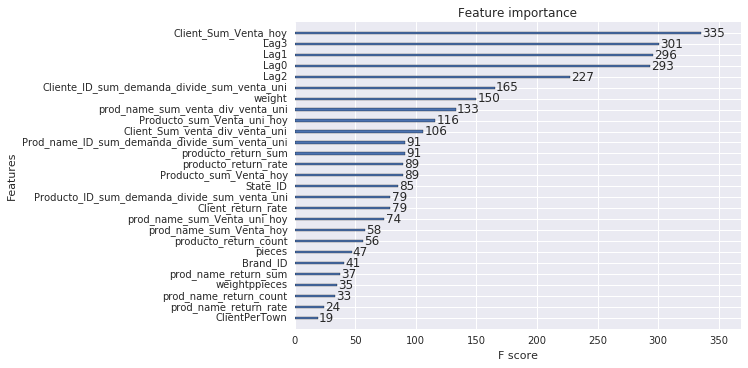

In [18]:
defaultParams = {"max_depth":6, "subsample":1., "min_child_weight":5, "colsample_bytree":0.4, "missing":np.nan
                ,"n_estimators":500, "learning_rate":0.1}
xgb_model1 = xgb.XGBRegressor(**defaultParams) 


xgb_model1.fit(X_train,y_train,eval_set=[(X_train, y_train),(X_test, y_test)],
         verbose=1, early_stopping_rounds = 10)


predictions = xgb_model1.predict(X_train,ntree_limit  = xgb_model1.best_iteration+1)
predictionsTest = xgb_model1.predict(X_test,ntree_limit  = xgb_model1.best_iteration+1)

print "trainResult: ", np.sqrt(mean_squared_error(y_train, predictions))
print "testResult: ", np.sqrt(mean_squared_error(y_test, predictionsTest))
print "Best Iteration: ", xgb_model1.best_iteration
print "Best Score: ", xgb_model1.best_score
print xgb.plot_importance(xgb_model1)

In [17]:
print("Pickling sklearn API models")
# must open in binary format to pickle
pickle.dump(xgb_model1, open("../../input/test1.pkl", "wb"))

Pickling sklearn API models


[0]	validation_0-rmse:1.27014
[1]	validation_0-rmse:1.17023
[2]	validation_0-rmse:1.06218
[3]	validation_0-rmse:0.97746
[4]	validation_0-rmse:0.903785
[5]	validation_0-rmse:0.826094
[6]	validation_0-rmse:0.768599
[7]	validation_0-rmse:0.718262
[8]	validation_0-rmse:0.662139
[9]	validation_0-rmse:0.611612
[10]	validation_0-rmse:0.579112
[11]	validation_0-rmse:0.552392
[12]	validation_0-rmse:0.528259
[13]	validation_0-rmse:0.507576
[14]	validation_0-rmse:0.477907
[15]	validation_0-rmse:0.463123
[16]	validation_0-rmse:0.451361
[17]	validation_0-rmse:0.440662
[18]	validation_0-rmse:0.421916
[19]	validation_0-rmse:0.40533
[20]	validation_0-rmse:0.391468
[21]	validation_0-rmse:0.386574
[22]	validation_0-rmse:0.375843
[23]	validation_0-rmse:0.372908
[24]	validation_0-rmse:0.36996
[25]	validation_0-rmse:0.367509
[26]	validation_0-rmse:0.357579
[27]	validation_0-rmse:0.34888
[28]	validation_0-rmse:0.347469
[29]	validation_0-rmse:0.341936
[30]	validation_0-rmse:0.340969
[31]	validation_0-rmse:0.

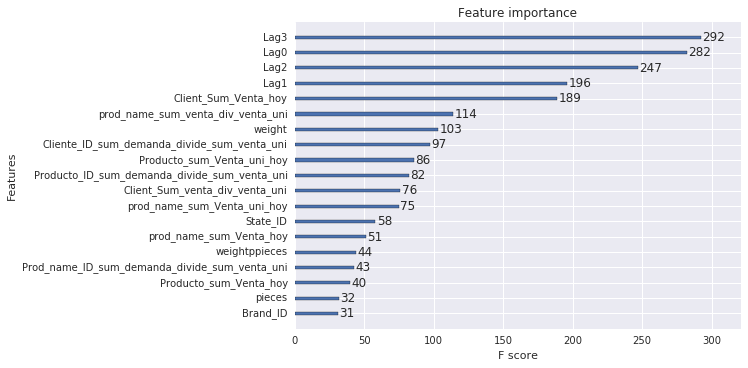

In [18]:
clf1 = pickle.load(open("../../input/test1.pkl", "rb"))
clf1.set_params(**{"n_estimators" : clf1.best_iteration+1})

clf1.fit(X_train,y_train, verbose=1, eval_set=[(X_train, y_train)])

predictions = clf1.predict(X_train,ntree_limit  = clf1.best_iteration+1)
predictionsTest = clf1.predict(X_test,ntree_limit  = clf1.best_iteration+1)

print "trainResult: ", np.sqrt(mean_squared_error(y_train, predictions))
print "testResult: ", np.sqrt(mean_squared_error(y_test, predictionsTest))
print "Best Iteration: ", clf1.best_iteration
print "Best Score: ", clf1.best_score
print xgb.plot_importance(clf1)

## Test2 XGBoost

In [19]:
X_train = FE.train[test2columns]
X_test = FE.test2[test2columns]
y_train = FE.train["Demanda_uni_equil"]
y_test = FE.test2["Demanda_uni_equil"]

In [20]:
print X_train.shape
print X_test.shape
print y_train.shape
print y_test.shape
gc.collect()

(20574686, 18)
(10408713, 18)
(20574686,)
(10408713,)


18785

[0]	validation_0-rmse:1.27622	validation_1-rmse:1.26888
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 10 rounds.
[1]	validation_0-rmse:1.17146	validation_1-rmse:1.16481
[2]	validation_0-rmse:1.08448	validation_1-rmse:1.0796
[3]	validation_0-rmse:0.985732	validation_1-rmse:0.988595
[4]	validation_0-rmse:0.897867	validation_1-rmse:0.909228
[5]	validation_0-rmse:0.832991	validation_1-rmse:0.846789
[6]	validation_0-rmse:0.77657	validation_1-rmse:0.792916
[7]	validation_0-rmse:0.733701	validation_1-rmse:0.752264
[8]	validation_0-rmse:0.675657	validation_1-rmse:0.705087
[9]	validation_0-rmse:0.625004	validation_1-rmse:0.665139
[10]	validation_0-rmse:0.580287	validation_1-rmse:0.631873
[11]	validation_0-rmse:0.552219	validation_1-rmse:0.607815
[12]	validation_0-rmse:0.515753	validation_1-rmse:0.584394
[13]	validation_0-rmse:0.485394	validation_1-rmse:0.565591
[14]	validation_0-rmse:0.466491	v

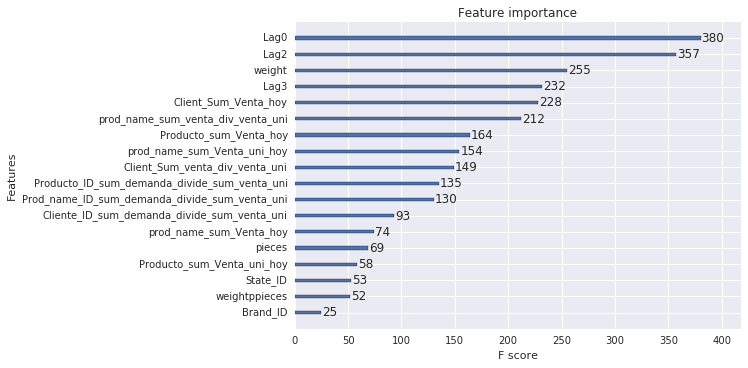

In [21]:
defaultParams = {"max_depth":6, "subsample":1., "min_child_weight":5, "colsample_bytree":0.4, "missing":np.nan
                ,"n_estimators":500, "learning_rate":0.1}
xgb_model2 = xgb.XGBRegressor(**defaultParams) 


xgb_model2.fit(X_train,y_train,eval_set=[(X_train, y_train),(X_test, y_test)],
         verbose=1, early_stopping_rounds = 10)


predictions = xgb_model2.predict(X_train,ntree_limit  = xgb_model2.best_iteration+1)
predictionsTest = xgb_model2.predict(X_test,ntree_limit  = xgb_model2.best_iteration+1)

print "trainResult: ", np.sqrt(mean_squared_error(y_train, predictions))
print "testResult: ", np.sqrt(mean_squared_error(y_test, predictionsTest))
print "Best Iteration: ", xgb_model2.best_iteration
print "Best Score: ", xgb_model2.best_score
print xgb.plot_importance(xgb_model2)

In [22]:
print("Pickling sklearn API models")
# must open in binary format to pickle
pickle.dump(xgb_model2, open("../../input/test2.pkl", "wb"))

Pickling sklearn API models


[0]	validation_0-rmse:1.27622
[1]	validation_0-rmse:1.17146
[2]	validation_0-rmse:1.08448
[3]	validation_0-rmse:0.985732
[4]	validation_0-rmse:0.897867
[5]	validation_0-rmse:0.832991
[6]	validation_0-rmse:0.77657
[7]	validation_0-rmse:0.733701
[8]	validation_0-rmse:0.675657
[9]	validation_0-rmse:0.625004
[10]	validation_0-rmse:0.580287
[11]	validation_0-rmse:0.552219
[12]	validation_0-rmse:0.515753
[13]	validation_0-rmse:0.485394
[14]	validation_0-rmse:0.466491
[15]	validation_0-rmse:0.450509
[16]	validation_0-rmse:0.429598
[17]	validation_0-rmse:0.419346
[18]	validation_0-rmse:0.410698
[19]	validation_0-rmse:0.404275
[20]	validation_0-rmse:0.391621
[21]	validation_0-rmse:0.378127
[22]	validation_0-rmse:0.36909
[23]	validation_0-rmse:0.359055
[24]	validation_0-rmse:0.356211
[25]	validation_0-rmse:0.353529
[26]	validation_0-rmse:0.348347
[27]	validation_0-rmse:0.346816
[28]	validation_0-rmse:0.34052
[29]	validation_0-rmse:0.339475
[30]	validation_0-rmse:0.338644
[31]	validation_0-rmse:0

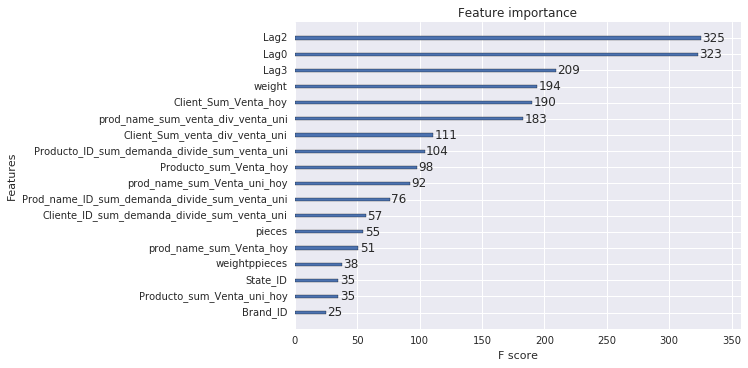

In [23]:
clf2 = pickle.load(open("../../input/test2.pkl", "rb"))

clf2.set_params(**{"n_estimators" : clf2.best_iteration+1})

clf2.fit(X_train,y_train, verbose=1, eval_set=[(X_train, y_train)])

predictions = clf2.predict(X_train,ntree_limit  = clf2.best_iteration+1)
predictionsTest = clf2.predict(X_test,ntree_limit  = clf2.best_iteration+1)

print "trainResult: ", np.sqrt(mean_squared_error(y_train, predictions))
print "testResult: ", np.sqrt(mean_squared_error(y_test, predictionsTest))
print "Best Iteration: ", clf2.best_iteration
print "Best Score: ", clf2.best_score
print xgb.plot_importance(clf2)

# STOP

## SEND TO PICKLE

In [37]:
print("Pickling sklearn API models 1")
# must open in binary format to pickle
pickle.dump(xgb_model1, open("../../input/LastShot.pkl", "wb"))
print("Pickling sklearn API models 2")
# must open in binary format to pickle
pickle.dump(xgb_model2, open("../../input/LastShot2.pkl", "wb"))

Pickling sklearn API models 1
Pickling sklearn API models 2


# Trial error STARTS HERE.

## Trial 1: 

In [1]:
test2columns = ['State_ID',
       'weight', 'pieces', 'Brand_ID', 'Lag0',
       'Lag2', 'Lag3', 'weightppieces', 'Client_Sum_Venta_hoy',
       'Client_Sum_Venta_uni_hoy', 'Client_Sum_venta_div_venta_uni',
       'prod_name_sum_Venta_hoy', 'prod_name_sum_Venta_uni_hoy',
       'prod_name_sum_venta_div_venta_uni', 'Producto_sum_Venta_hoy',
       'Producto_sum_Venta_uni_hoy', 'Producto_sum_venta_div_venta_uni',
       'Producto_ID_sum_demanda_divide_sum_venta_uni',
       'Prod_name_ID_sum_demanda_divide_sum_venta_uni',
       'Cliente_ID_sum_demanda_divide_sum_venta_uni', 'ClientPerTown',
       'client_return_sum', 'client_return_count', 'Client_return_rate',
       'producto_return_sum', 'producto_return_count',
       'producto_return_rate', 'prod_name_return_sum',
       'prod_name_return_count', 'prod_name_return_rate']

In [2]:
columns_to_remove = ['client_return_sum', 'client_return_count',
                     'Client_Sum_Venta_uni_hoy', 'Producto_sum_venta_div_venta_uni',
                    'producto_return_sum', 'producto_return_rate', 'Client_return_rate',
                     'prod_name_return_rate', 'prod_name_return_count', 'ClientPerTown',
                     'prod_name_return_sum', 'producto_return_count', 'Brand_ID'
                    ]

In [3]:
test2columns = list ( set(test2columns) - set(columns_to_remove))

In [4]:
test1columns = test2columns + ['Lag1']

In [30]:
X_train = FE.train[test1columns]
X_test = FE.test1[test1columns]
y_train = FE.train["Demanda_uni_equil"]
y_test = FE.test1["Demanda_uni_equil"]

[0]	validation_0-rmse:1.27074	validation_1-rmse:1.2683
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 10 rounds.
[1]	validation_0-rmse:1.16409	validation_1-rmse:1.1621
[2]	validation_0-rmse:1.07127	validation_1-rmse:1.07086
[3]	validation_0-rmse:0.989044	validation_1-rmse:0.988056
[4]	validation_0-rmse:0.901431	validation_1-rmse:0.907533
[5]	validation_0-rmse:0.837272	validation_1-rmse:0.844284
[6]	validation_0-rmse:0.779991	validation_1-rmse:0.788358
[7]	validation_0-rmse:0.731489	validation_1-rmse:0.74116
[8]	validation_0-rmse:0.673485	validation_1-rmse:0.693991
[9]	validation_0-rmse:0.636684	validation_1-rmse:0.660017
[10]	validation_0-rmse:0.592906	validation_1-rmse:0.625271
[11]	validation_0-rmse:0.568484	validation_1-rmse:0.602862
[12]	validation_0-rmse:0.54517	validation_1-rmse:0.581735
[13]	validation_0-rmse:0.511898	validation_1-rmse:0.560144
[14]	validation_0-rmse:0.481944	val

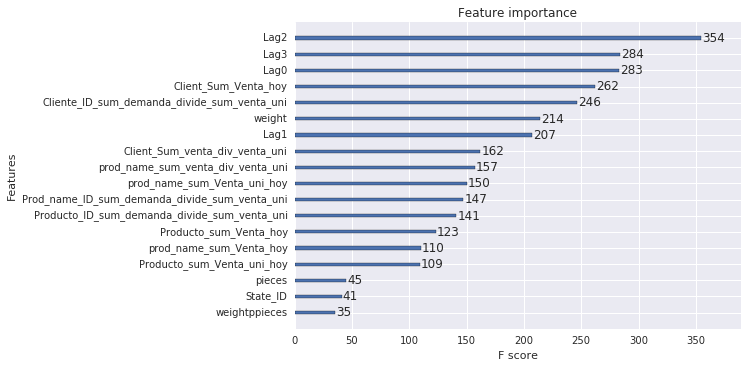

In [31]:
defaultParams = {"max_depth":6, "subsample":1., "min_child_weight":5, "colsample_bytree":0.4, "missing":np.nan
                ,"n_estimators":500, "learning_rate":0.1}
xgb_model1 = xgb.XGBRegressor(**defaultParams) 


xgb_model1.fit(X_train,y_train,eval_set=[(X_train, y_train),(X_test, y_test)],
         verbose=1, early_stopping_rounds = 10)


predictions = xgb_model1.predict(X_train,ntree_limit  = xgb_model1.best_iteration+1)
predictionsTest = xgb_model1.predict(X_test,ntree_limit  = xgb_model1.best_iteration+1)

print "trainResult: ", np.sqrt(mean_squared_error(y_train, predictions))
print "testResult: ", np.sqrt(mean_squared_error(y_test, predictionsTest))
print "Best Iteration: ", xgb_model1.best_iteration
print "Best Score: ", xgb_model1.best_score
print xgb.plot_importance(xgb_model1)

In [32]:
X_train = FE.train[test2columns]
X_test = FE.test2[test2columns]
y_train = FE.train["Demanda_uni_equil"]
y_test = FE.test2["Demanda_uni_equil"]

[0]	validation_0-rmse:1.27083	validation_1-rmse:1.26463
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 10 rounds.
[1]	validation_0-rmse:1.17998	validation_1-rmse:1.17515
[2]	validation_0-rmse:1.07066	validation_1-rmse:1.07276
[3]	validation_0-rmse:0.988172	validation_1-rmse:0.993965
[4]	validation_0-rmse:0.913282	validation_1-rmse:0.921188
[5]	validation_0-rmse:0.848903	validation_1-rmse:0.859625
[6]	validation_0-rmse:0.777259	validation_1-rmse:0.797999
[7]	validation_0-rmse:0.727134	validation_1-rmse:0.750506
[8]	validation_0-rmse:0.683322	validation_1-rmse:0.709413
[9]	validation_0-rmse:0.645272	validation_1-rmse:0.673809
[10]	validation_0-rmse:0.614013	validation_1-rmse:0.64548
[11]	validation_0-rmse:0.573393	validation_1-rmse:0.615403
[12]	validation_0-rmse:0.536279	validation_1-rmse:0.591174
[13]	validation_0-rmse:0.515994	validation_1-rmse:0.573803
[14]	validation_0-rmse:0.498791	

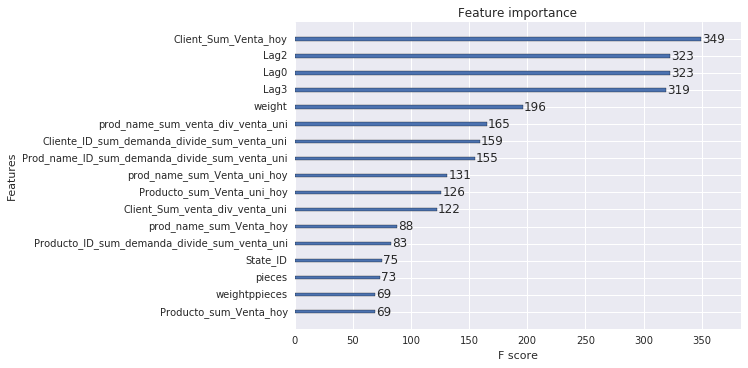

In [33]:
defaultParams = {"max_depth":6, "subsample":1., "min_child_weight":5, "colsample_bytree":0.4, "missing":np.nan
                ,"n_estimators":500, "learning_rate":0.1}
xgb_model2 = xgb.XGBRegressor(**defaultParams) 


xgb_model2.fit(X_train,y_train,eval_set=[(X_train, y_train),(X_test, y_test)],
         verbose=1, early_stopping_rounds = 10)


predictions = xgb_model2.predict(X_train,ntree_limit  = xgb_model2.best_iteration+1)
predictionsTest = xgb_model2.predict(X_test,ntree_limit  = xgb_model2.best_iteration+1)

print "trainResult: ", np.sqrt(mean_squared_error(y_train, predictions))
print "testResult: ", np.sqrt(mean_squared_error(y_test, predictionsTest))
print "Best Iteration: ", xgb_model2.best_iteration
print "Best Score: ", xgb_model2.best_score
print xgb.plot_importance(xgb_model2)

## Trial 2: Recreating base submission 

In [34]:
test2columns = ['State_ID',
       'weight', 'pieces', 'Brand_ID', 'Lag0',
       'Lag2', 'Lag3', 'weightppieces', 'Client_Sum_Venta_hoy',
       'Client_Sum_Venta_uni_hoy', 'Client_Sum_venta_div_venta_uni',
       'prod_name_sum_Venta_hoy', 'prod_name_sum_Venta_uni_hoy',
       'prod_name_sum_venta_div_venta_uni', 'Producto_sum_Venta_hoy',
       'Producto_sum_Venta_uni_hoy', 'Producto_sum_venta_div_venta_uni',
       'Producto_ID_sum_demanda_divide_sum_venta_uni',
       'Prod_name_ID_sum_demanda_divide_sum_venta_uni',
       'Cliente_ID_sum_demanda_divide_sum_venta_uni', 'ClientPerTown',
       'client_return_sum', 'client_return_count', 'Client_return_rate',
       'producto_return_sum', 'producto_return_count',
       'producto_return_rate', 'prod_name_return_sum',
       'prod_name_return_count', 'prod_name_return_rate']

columns_to_remove = ['client_return_sum', 'client_return_count',
                     'Client_Sum_Venta_uni_hoy', 'Producto_sum_venta_div_venta_uni'
                    ]

test2columns = list ( set(test2columns) - set(columns_to_remove))

test1columns = test2columns + ['Lag1']

[0]	validation_0-rmse:1.25689	validation_1-rmse:1.25886
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 10 rounds.
[1]	validation_0-rmse:1.15734	validation_1-rmse:1.16092
[2]	validation_0-rmse:1.07838	validation_1-rmse:1.0836
[3]	validation_0-rmse:0.979943	validation_1-rmse:0.992262
[4]	validation_0-rmse:0.917812	validation_1-rmse:0.931038
[5]	validation_0-rmse:0.848682	validation_1-rmse:0.864158
[6]	validation_0-rmse:0.775473	validation_1-rmse:0.800698
[7]	validation_0-rmse:0.732975	validation_1-rmse:0.759962
[8]	validation_0-rmse:0.685626	validation_1-rmse:0.715285
[9]	validation_0-rmse:0.644549	validation_1-rmse:0.677956
[10]	validation_0-rmse:0.609226	validation_1-rmse:0.646117
[11]	validation_0-rmse:0.581233	validation_1-rmse:0.620759
[12]	validation_0-rmse:0.557174	validation_1-rmse:0.598973
[13]	validation_0-rmse:0.532793	validation_1-rmse:0.577044
[14]	validation_0-rmse:0.518532	

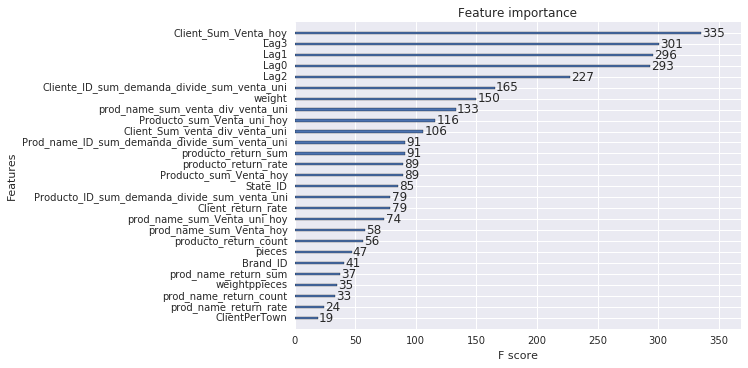

In [35]:
X_train = FE.train[test1columns]
X_test = FE.test1[test1columns]
y_train = FE.train["Demanda_uni_equil"]
y_test = FE.test1["Demanda_uni_equil"]

defaultParams = {"max_depth":6, "subsample":1., "min_child_weight":5, "colsample_bytree":0.4, "missing":np.nan
                ,"n_estimators":500, "learning_rate":0.1}
xgb_model1 = xgb.XGBRegressor(**defaultParams) 


xgb_model1.fit(X_train,y_train,eval_set=[(X_train, y_train),(X_test, y_test)],
         verbose=1, early_stopping_rounds = 10)


predictions = xgb_model1.predict(X_train,ntree_limit  = xgb_model1.best_iteration+1)
predictionsTest = xgb_model1.predict(X_test,ntree_limit  = xgb_model1.best_iteration+1)

print "trainResult: ", np.sqrt(mean_squared_error(y_train, predictions))
print "testResult: ", np.sqrt(mean_squared_error(y_test, predictionsTest))
print "Best Iteration: ", xgb_model1.best_iteration
print "Best Score: ", xgb_model1.best_score
print xgb.plot_importance(xgb_model1)

[0]	validation_0-rmse:1.25689	validation_1-rmse:1.25362
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 10 rounds.
[1]	validation_0-rmse:1.13938	validation_1-rmse:1.14299
[2]	validation_0-rmse:1.04673	validation_1-rmse:1.05426
[3]	validation_0-rmse:0.967984	validation_1-rmse:0.978254
[4]	validation_0-rmse:0.904829	validation_1-rmse:0.916891
[5]	validation_0-rmse:0.826111	validation_1-rmse:0.847435
[6]	validation_0-rmse:0.768603	validation_1-rmse:0.794655
[7]	validation_0-rmse:0.717967	validation_1-rmse:0.748098
[8]	validation_0-rmse:0.661699	validation_1-rmse:0.702276
[9]	validation_0-rmse:0.629848	validation_1-rmse:0.673854
[10]	validation_0-rmse:0.583021	validation_1-rmse:0.639205
[11]	validation_0-rmse:0.543436	validation_1-rmse:0.611007
[12]	validation_0-rmse:0.517247	validation_1-rmse:0.589452
[13]	validation_0-rmse:0.494691	validation_1-rmse:0.571078
[14]	validation_0-rmse:0.46572	

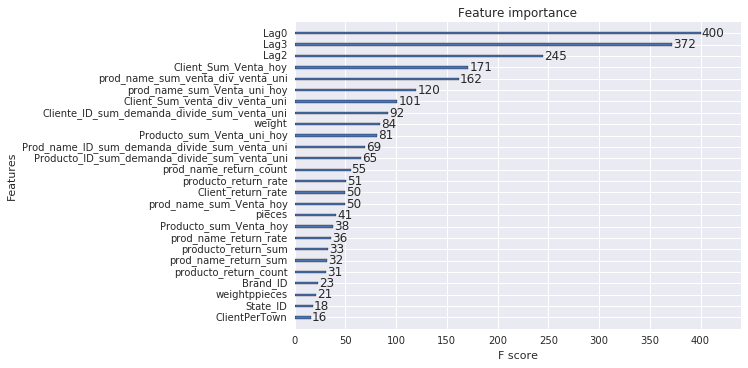

In [36]:
X_train = FE.train[test2columns]
X_test = FE.test2[test2columns]
y_train = FE.train["Demanda_uni_equil"]
y_test = FE.test2["Demanda_uni_equil"]

defaultParams = {"max_depth":6, "subsample":1., "min_child_weight":5, "colsample_bytree":0.4, "missing":np.nan
                ,"n_estimators":500, "learning_rate":0.1}
xgb_model2 = xgb.XGBRegressor(**defaultParams) 


xgb_model2.fit(X_train,y_train,eval_set=[(X_train, y_train),(X_test, y_test)],
         verbose=1, early_stopping_rounds = 10)


predictions = xgb_model2.predict(X_train,ntree_limit  = xgb_model2.best_iteration+1)
predictionsTest = xgb_model2.predict(X_test,ntree_limit  = xgb_model2.best_iteration+1)

print "trainResult: ", np.sqrt(mean_squared_error(y_train, predictions))
print "testResult: ", np.sqrt(mean_squared_error(y_test, predictionsTest))
print "Best Iteration: ", xgb_model2.best_iteration
print "Best Score: ", xgb_model2.best_score
print xgb.plot_importance(xgb_model2)

## Trial 3: XGboost infinity problem 

In [8]:
test2columns = ['State_ID',
       'weight', 'pieces', 'Brand_ID', 'Lag0',
       'Lag2', 'Lag3', 'weightppieces', 'Client_Sum_Venta_hoy',
       'Client_Sum_Venta_uni_hoy', 'Client_Sum_venta_div_venta_uni',
       'prod_name_sum_Venta_hoy', 'prod_name_sum_Venta_uni_hoy',
       'prod_name_sum_venta_div_venta_uni', 'Producto_sum_Venta_hoy',
       'Producto_sum_Venta_uni_hoy', 'Producto_sum_venta_div_venta_uni',
       'Producto_ID_sum_demanda_divide_sum_venta_uni',
       'Prod_name_ID_sum_demanda_divide_sum_venta_uni',
       'Cliente_ID_sum_demanda_divide_sum_venta_uni', 'ClientPerTown',
       'client_return_sum', 'client_return_count', 'Client_return_rate',
       'producto_return_sum', 'producto_return_count',
       'producto_return_rate', 'prod_name_return_sum',
       'prod_name_return_count', 'prod_name_return_rate']

columns_to_remove = ['client_return_sum', 'client_return_count',
                     'Client_Sum_Venta_uni_hoy', 'Producto_sum_venta_div_venta_uni'
                    ]

test2columns = list ( set(test2columns) - set(columns_to_remove))

test1columns = test2columns + ['Lag1']

In [9]:
X_train = FE.train[test1columns].copy()
X_test = FE.test1[test1columns].copy()
y_train = FE.train["Demanda_uni_equil"]
y_test = FE.test1["Demanda_uni_equil"]
gc.collect()

0

In [10]:
del FE.train, FE.test1, FE.test2
gc.collect()

31

X_train.loc[:,"Lag2_div_Lag0"]= X_train["Lag2"]/X_train["Lag0"]
X_train.loc[:,"Lag3_div_Lag0"]= X_train["Lag3"]/X_train["Lag0"]
X_train.loc[:,"Lag1_div_Lag2"]= X_train["Lag1"]/X_train["Lag2"]
X_train.loc[:,"Lag1_div_Lag3"]= X_train["Lag1"]/X_train["Lag3"]
X_train.loc[:,"Lag2_div_Lag3"]= X_train["Lag2"]/X_train["Lag3"]

gc.collect()
X_train.loc[:,"Lag1_minus_Lag0"]= X_train["Lag1"]-X_train["Lag0"]
X_train.loc[:,"Lag2_minus_Lag0"]= X_train["Lag2"]-X_train["Lag0"]
X_train.loc[:,"Lag3_minus_Lag0"]= X_train["Lag3"]-X_train["Lag0"]
X_train.loc[:,"Lag1_minus_Lag2"]= X_train["Lag1"]-X_train["Lag2"]
X_train.loc[:,"Lag1_minus_Lag3"]= X_train["Lag1"]-X_train["Lag3"]
X_train.loc[:,"Lag2_minus_Lag3"]= X_train["Lag2"]-X_train["Lag3"]

X_train.loc[:,"Lag1_div_Lag0"]= X_train["Lag1"]/X_train["Lag0"]
X_train.loc[:,"Lag2_div_Lag0"]= X_train["Lag2"]/X_train["Lag0"]
X_train.loc[:,"Lag3_div_Lag0"]= X_train["Lag3"]/X_train["Lag0"]
X_train.loc[:,"Lag1_div_Lag2"]= X_train["Lag1"]/X_train["Lag2"]
X_train.loc[:,"Lag1_div_Lag3"]= X_train["Lag1"]/X_train["Lag3"]
X_train.loc[:,"Lag2_div_Lag3"]= X_train["Lag2"]/X_train["Lag3"]

gc.collect()
X_train.loc[:,"Lag1_minus_Lag0"]= X_train["Lag1"]-X_train["Lag0"]
X_train.loc[:,"Lag2_minus_Lag0"]= X_train["Lag2"]-X_train["Lag0"]
X_train.loc[:,"Lag3_minus_Lag0"]= X_train["Lag3"]-X_train["Lag0"]
X_train.loc[:,"Lag1_minus_Lag2"]= X_train["Lag1"]-X_train["Lag2"]
X_train.loc[:,"Lag1_minus_Lag3"]= X_train["Lag1"]-X_train["Lag3"]
X_train.loc[:,"Lag2_minus_Lag3"]= X_train["Lag2"]-X_train["Lag3"]

#X_train.loc[:,"Lag2Lag1Lag3_div_3Lag0"]= (X_train["Lag1"]+X_train["Lag2"]+X_train["Lag3"]) / (3*X_train["Lag0"])
#X_train.loc[:,"Lag2Lag1Lag3_min_3Lag0"]= (X_train["Lag1"]+X_train["Lag2"]+X_train["Lag3"]) - (3*X_train["Lag0"])

#X_train.loc[:,"CF_1x2"] = X_train["Client_Sum_Venta_hoy"] * X_train["Cliente_ID_sum_demanda_divide_sum_venta_uni"]
#X_train.loc[:,"CF_3x6"] = X_train["prod_name_sum_venta_div_venta_uni"] * X_train.loc[:,"Prod_name_ID_sum_demanda_divide_sum_venta_uni"]

#X_train.loc[:,"CF_2x3"] = X_train["Cliente_ID_sum_demanda_divide_sum_venta_uni"] * X_train.loc[:,"prod_name_sum_venta_div_venta_uni"]

#X_train.loc[:,"CF_1d5"] = X_train["Client_Sum_Venta_hoy"] / X_train["Client_Sum_venta_div_venta_uni"]
gc.collect()

X_test.loc[:,"Lag1_div_Lag0"]= X_test["Lag1"]/X_test["Lag0"]
X_test.loc[:,"Lag2_div_Lag0"]= X_test["Lag2"]/X_test["Lag0"]
X_test.loc[:,"Lag3_div_Lag0"]= X_test["Lag3"]/X_test["Lag0"]
X_test.loc[:,"Lag1_div_Lag2"]= X_test["Lag1"]/X_test["Lag2"]
X_test.loc[:,"Lag1_div_Lag3"]= X_test["Lag1"]/X_test["Lag3"]
X_test.loc[:,"Lag2_div_Lag3"]= X_test["Lag2"]/X_test["Lag3"]


X_test.loc[:,"Lag1_minus_Lag0"]= X_test["Lag1"]-X_test["Lag0"]
X_test.loc[:,"Lag2_minus_Lag0"]= X_test["Lag2"]-X_test["Lag0"]
X_test.loc[:,"Lag3_minus_Lag0"]= X_test["Lag3"]-X_test["Lag0"]
X_test.loc[:,"Lag1_minus_Lag2"]= X_test["Lag1"]-X_test["Lag2"]
X_test.loc[:,"Lag1_minus_Lag3"]= X_test["Lag1"]-X_test["Lag3"]
X_test.loc[:,"Lag2_minus_Lag3"]= X_test["Lag2"]-X_test["Lag3"]

#X_test.loc[:,"Lag2Lag1Lag3_div_3Lag0"]= (X_test["Lag1"]+X_test["Lag2"]+X_test["Lag3"]) / (3*X_test["Lag0"])
#X_test.loc[:,"Lag2Lag1Lag3_min_3Lag0"]= (X_test["Lag1"]+X_test["Lag2"]+X_test["Lag3"]) - (3*X_test["Lag0"])

#X_test.loc[:,"CF_1x2"] = X_test["Client_Sum_Venta_hoy"] * X_test["Cliente_ID_sum_demanda_divide_sum_venta_uni"]
#X_test.loc[:,"CF_3x6"] = X_test["prod_name_sum_venta_div_venta_uni"] * X_test.loc[:,"Prod_name_ID_sum_demanda_divide_sum_venta_uni"]

#X_test.loc[:,"CF_2x3"] = X_test["Cliente_ID_sum_demanda_divide_sum_venta_uni"] * X_test.loc[:,"prod_name_sum_venta_div_venta_uni"]

#X_test.loc[:,"CF_1d5"] = X_test["Client_Sum_Venta_hoy"] / X_test["Client_Sum_venta_div_venta_uni"]
gc.collect()

In [10]:


gc.collect()
X_train.loc[:,"Lag1_minus_Lag0"]= X_train["Lag1"].values-X_train["Lag0"].values
X_train.loc[:,"Lag2_minus_Lag0"]= X_train["Lag2"].values-X_train["Lag0"].values
X_train.loc[:,"Lag3_minus_Lag0"]= X_train["Lag3"].values-X_train["Lag0"].values
X_train.loc[:,"Lag1_minus_Lag2"]= X_train["Lag1"].values-X_train["Lag2"].values
X_train.loc[:,"Lag1_minus_Lag3"]= X_train["Lag1"].values-X_train["Lag3"].values
X_train.loc[:,"Lag2_minus_Lag3"]= X_train["Lag2"].values-X_train["Lag3"].values

#X_train.loc[:,"Lag2Lag1Lag3_div_3Lag0"]= (X_train["Lag1"].values+X_train["Lag2"].values+X_train["Lag3"].values) / (3*X_train["Lag0"].values)
#X_train.loc[:,"Lag2Lag1Lag3_min_3Lag0"]= (X_train["Lag1"].values+X_train["Lag2"].values+X_train["Lag3"].values) - (3*X_train["Lag0"].values)

X_train.loc[:,"CF_1x2"] = X_train["Client_Sum_Venta_hoy"].values * X_train["Cliente_ID_sum_demanda_divide_sum_venta_uni"].values
X_train.loc[:,"CF_3x6"] = X_train["prod_name_sum_venta_div_venta_uni"].values * X_train.loc[:,"Prod_name_ID_sum_demanda_divide_sum_venta_uni"].values

X_train.loc[:,"CF_2x3"] = X_train["Cliente_ID_sum_demanda_divide_sum_venta_uni"].values * X_train.loc[:,"prod_name_sum_venta_div_venta_uni"].values

#X_train.loc[:,"CF_1d5"] = X_train["Client_Sum_Venta_hoy"].values / X_train["Client_Sum_venta_div_venta_uni"].values
gc.collect()



X_test.loc[:,"Lag1_minus_Lag0"]= X_test["Lag1"].values-X_test["Lag0"].values
X_test.loc[:,"Lag2_minus_Lag0"]= X_test["Lag2"].values-X_test["Lag0"].values
X_test.loc[:,"Lag3_minus_Lag0"]= X_test["Lag3"].values-X_test["Lag0"].values
X_test.loc[:,"Lag1_minus_Lag2"]= X_test["Lag1"].values-X_test["Lag2"].values
X_test.loc[:,"Lag1_minus_Lag3"]= X_test["Lag1"].values-X_test["Lag3"].values
X_test.loc[:,"Lag2_minus_Lag3"]= X_test["Lag2"].values-X_test["Lag3"].values

#X_test.loc[:,"Lag2Lag1Lag3_div_3Lag0"]= (X_test["Lag1"].values+X_test["Lag2"].values+X_test["Lag3"].values) / (3*X_test["Lag0"].values)
#X_test.loc[:,"Lag2Lag1Lag3_min_3Lag0"]= (X_test["Lag1"].values+X_test["Lag2"].values+X_test["Lag3"].values) - (3*X_test["Lag0"].values)

X_test.loc[:,"CF_1x2"] = X_test["Client_Sum_Venta_hoy"].values * X_test["Cliente_ID_sum_demanda_divide_sum_venta_uni"].values
X_test.loc[:,"CF_3x6"] = X_test["prod_name_sum_venta_div_venta_uni"].values * X_test.loc[:,"Prod_name_ID_sum_demanda_divide_sum_venta_uni"].values

X_test.loc[:,"CF_2x3"] = X_test["Cliente_ID_sum_demanda_divide_sum_venta_uni"].values * X_test.loc[:,"prod_name_sum_venta_div_venta_uni"].values

#X_test.loc[:,"CF_1d5"] = X_test["Client_Sum_Venta_hoy"].values / X_test["Client_Sum_venta_div_venta_uni"].values
gc.collect()

86

In [11]:
#X_train.info()
corrDf = FE.train.corr()
corrDf.to_csv('../../input/coordfX.csv')

[0]	validation_0-rmse:1.25681	validation_1-rmse:1.25881
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 10 rounds.
[1]	validation_0-rmse:1.13869	validation_1-rmse:1.14693
[2]	validation_0-rmse:1.03314	validation_1-rmse:1.04883
[3]	validation_0-rmse:0.947123	validation_1-rmse:0.967255
[4]	validation_0-rmse:0.871832	validation_1-rmse:0.894794
[5]	validation_0-rmse:0.802724	validation_1-rmse:0.831135
[6]	validation_0-rmse:0.744082	validation_1-rmse:0.776066
[7]	validation_0-rmse:0.688887	validation_1-rmse:0.728929
[8]	validation_0-rmse:0.635725	validation_1-rmse:0.685848
[9]	validation_0-rmse:0.594572	validation_1-rmse:0.655814
[10]	validation_0-rmse:0.551047	validation_1-rmse:0.624391
[11]	validation_0-rmse:0.520221	validation_1-rmse:0.599224
[12]	validation_0-rmse:0.485687	validation_1-rmse:0.577339
[13]	validation_0-rmse:0.458496	validation_1-rmse:0.560267
[14]	validation_0-rmse:0.434161

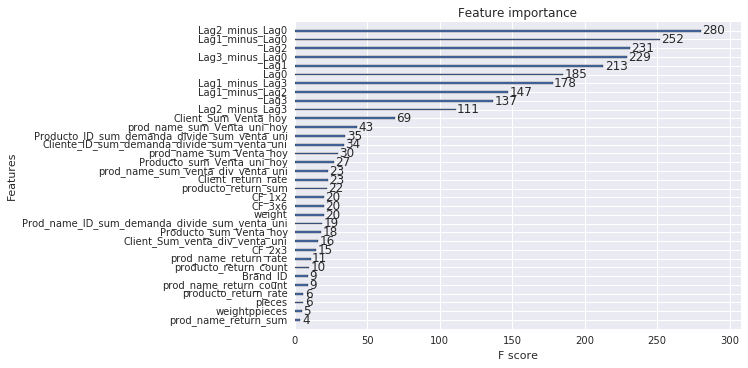

In [12]:
defaultParams = {"max_depth":6, "subsample":1., "min_child_weight":5, "colsample_bytree":0.4, "missing":np.nan
                ,"n_estimators":500, "learning_rate":0.1}
xgb_model1 = xgb.XGBRegressor(**defaultParams) 


xgb_model1.fit(X_train,y_train,eval_set=[(X_train, y_train),(X_test, y_test)],
         verbose=1, early_stopping_rounds = 10)


predictions = xgb_model1.predict(X_train,ntree_limit  = xgb_model1.best_iteration+1)
predictionsTest = xgb_model1.predict(X_test,ntree_limit  = xgb_model1.best_iteration+1)

print "trainResult: ", np.sqrt(mean_squared_error(y_train, predictions))
print "testResult: ", np.sqrt(mean_squared_error(y_test, predictionsTest))
print "Best Iteration: ", xgb_model1.best_iteration
print "Best Score: ", xgb_model1.best_score
print xgb.plot_importance(xgb_model1)

In [36]:
X_train.corr()

,weight,Producto_sum_Venta_hoy,pieces,producto_return_sum,prod_name_sum_Venta_hoy,Producto_sum_Venta_uni_hoy,Prod_name_ID_sum_demanda_divide_sum_venta_uni,producto_return_rate,Cliente_ID_sum_demanda_divide_sum_venta_uni,Client_return_rate,...,weightppieces,producto_return_count,Producto_ID_sum_demanda_divide_sum_venta_uni,Lag1,Lag1_minus_Lag0,Lag2_minus_Lag0,Lag3_minus_Lag0,Lag1_minus_Lag2,Lag1_minus_Lag3,Lag2_minus_Lag3
weight,1.000000,0.244353,0.043060,-0.064900,0.370473,-0.127946,-0.057549,-0.039030,-0.000792,0.006449,...,-0.135139,-0.005947,-0.043670,-0.094870,0.006034,0.019339,0.034695,-0.012570,-0.025325,-0.014977
Producto_sum_Venta_hoy,0.244353,1.000000,-0.137064,0.561960,0.719610,0.690966,0.132392,-0.112434,-0.022777,0.004325,...,-0.057359,0.813216,0.146167,0.061799,0.007406,0.019153,0.017309,-0.011210,-0.009129,0.001289
pieces,0.043060,-0.137064,1.000000,-0.120916,-0.149635,-0.050165,0.112029,-0.010299,0.006253,0.000053,...,0.014778,-0.131786,0.089531,0.101273,-0.006334,-0.007212,0.003402,0.001148,-0.008005,-0.009863
producto_return_sum,-0.064900,0.561960,-0.120916,1.000000,0.204980,0.459712,-0.115956,0.050647,-0.021634,0.001867,...,0.084664,0.752237,-0.092598,-0.074822,-0.004420,0.005222,0.021923,-0.008637,-0.022567,-0.015913
prod_name_sum_Venta_hoy,0.370473,0.719610,-0.149635,0.204980,1.000000,0.451539,0.163610,-0.114848,-0.011710,-0.000886,...,-0.030556,0.409999,0.136534,0.123985,0.007065,0.013587,0.014383,-0.006382,-0.006859,-0.001074
Producto_sum_Venta_uni_hoy,-0.127946,0.690966,-0.050165,0.459712,0.451539,1.000000,0.263164,-0.120238,-0.018870,0.003504,...,0.192737,0.742027,0.244696,0.315278,0.015864,0.003672,-0.026480,0.010369,0.035650,0.028418
Prod_name_ID_sum_demanda_divide_sum_venta_uni,-0.057549,0.132392,0.112029,-0.115956,0.163610,0.263164,1.000000,-0.509351,0.018795,-0.027700,...,-0.020600,0.126458,0.844985,0.194528,-0.009967,-0.006706,-0.018510,-0.002466,0.008130,0.011319
producto_return_rate,-0.039030,-0.112434,-0.010299,0.050647,-0.114848,-0.120238,-0.509351,1.000000,-0.025988,0.048601,...,-0.021964,-0.131855,-0.579862,-0.033558,0.004565,0.003721,0.045966,0.000532,-0.036286,-0.040027
Cliente_ID_sum_demanda_divide_sum_venta_uni,-0.000792,-0.022777,0.006253,-0.021634,-0.011710,-0.018870,0.018795,-0.025988,1.000000,-0.602067,...,0.004715,-0.021828,0.025413,0.045053,-0.082486,-0.084872,-0.085896,0.006627,0.008837,0.002982
Client_return_rate,0.006449,0.004325,0.000053,0.001867,-0.000886,0.003504,-0.027700,0.048601,-0.602067,1.000000,...,-0.006399,-0.001131,-0.035080,-0.010962,0.065557,0.070389,0.071389,-0.007969,-0.009735,-0.002616


In [ ]:
X_train = FE.train[test2columns].copy()
gc.collect()
X_test = FE.test2[test2columns].copy()
gc.collect()
y_train = FE.train["Demanda_uni_equil"]
y_test = FE.test2["Demanda_uni_equil"]
gc.collect()

In [ ]:
X_train.loc[:,"Lag2_div_Lag0"]= X_train["Lag2"].values/X_train["Lag0"].values
X_train.loc[:,"Lag3_div_Lag0"]= X_train["Lag3"].values/X_train["Lag0"].values


X_train.loc[:,"Lag2_div_Lag3"]= X_train["Lag2"].values/X_train["Lag3"].values



X_train.loc[:,"Lag2_minus_Lag0"]= X_train["Lag2"].values-X_train["Lag0"].values
X_train.loc[:,"Lag3_minus_Lag0"]= X_train["Lag3"].values-X_train["Lag0"].values

X_train.loc[:,"Lag2_minus_Lag3"]= X_train["Lag2"].values-X_train["Lag3"].values

#X_train.loc[:,"Lag2Lag3_div_3Lag0"]= (X_train["Lag2"].values+X_train["Lag3"].values) / (2*X_train["Lag0"].values)
#X_train.loc[:,"Lag2Lag3_min_3Lag0"]= (X_train["Lag2"].values+X_train["Lag3"].values) - (2*X_train["Lag0"].values)

#X_train.loc[:,"CF_1x2"] = X_train["Client_Sum_Venta_hoy"].values * X_train["Cliente_ID_sum_demanda_divide_sum_venta_uni"].values
#X_train.loc[:,"CF_3x6"] = X_train["prod_name_sum_venta_div_venta_uni"].values *X_train.loc[:,"Prod_name_ID_sum_demanda_divide_sum_venta_uni"].values

#X_train.loc[:,"CF_2x3"] = X_train["Cliente_ID_sum_demanda_divide_sum_venta_uni"].values *X_train.loc[:,"prod_name_sum_venta_div_venta_uni"].values

#X_train.loc[:,"CF_1d5"] = X_train["Client_Sum_Venta_hoy"].values / X_train["Client_Sum_venta_div_venta_uni"].values
gc.collect()


X_test.loc[:,"Lag2_div_Lag0"]= X_test["Lag2"].values/X_test["Lag0"].values
X_test.loc[:,"Lag3_div_Lag0"]= X_test["Lag3"].values/X_test["Lag0"].values


X_test.loc[:,"Lag2_div_Lag3"]= X_test["Lag2"].values/X_test["Lag3"].values



X_test.loc[:,"Lag2_minus_Lag0"]= X_test["Lag2"].values-X_test["Lag0"].values
X_test.loc[:,"Lag3_minus_Lag0"]= X_test["Lag3"].values-X_test["Lag0"].values

X_test.loc[:,"Lag2_minus_Lag3"]= X_test["Lag2"].values-X_test["Lag3"].values

#X_test.loc[:,"Lag2Lag3_div_3Lag0"]= (X_test["Lag2"].values+X_test["Lag3"].values) / (2*X_test["Lag0"].values)
#X_test.loc[:,"Lag2Lag3_min_3Lag0"]= (X_test["Lag2"].values+X_test["Lag3"].values) - (2*X_test["Lag0"].values)

#X_test.loc[:,"CF_1x2"] = X_test["Client_Sum_Venta_hoy"].values * X_test["Cliente_ID_sum_demanda_divide_sum_venta_uni"].values
#X_test.loc[:,"CF_3x6"] = X_test["prod_name_sum_venta_div_venta_uni"].values *X_test.loc[:,"Prod_name_ID_sum_demanda_divide_sum_venta_uni"].values

#X_test.loc[:,"CF_2x3"] = X_test["Cliente_ID_sum_demanda_divide_sum_venta_uni"].values *X_test.loc[:,"prod_name_sum_venta_div_venta_uni"].values

#X_test.loc[:,"CF_1d5"] = X_test["Client_Sum_Venta_hoy"].values / X_test["Client_Sum_venta_div_venta_uni"].values

gc.collect()


In [ ]:
defaultParams = {"max_depth":6, "subsample":1., "min_child_weight":5, "colsample_bytree":0.4, "missing":np.nan
                ,"n_estimators":500, "learning_rate":0.1}
xgb_model2 = xgb.XGBRegressor(**defaultParams) 


xgb_model2.fit(X_train,y_train,eval_set=[(X_train, y_train),(X_test, y_test)],
         verbose=1, early_stopping_rounds = 10)


predictions = xgb_model2.predict(X_train,ntree_limit  = xgb_model2.best_iteration+1)
predictionsTest = xgb_model2.predict(X_test,ntree_limit  = xgb_model2.best_iteration+1)

print "trainResult: ", np.sqrt(mean_squared_error(y_train, predictions))
print "testResult: ", np.sqrt(mean_squared_error(y_test, predictionsTest))
print "Best Iteration: ", xgb_model2.best_iteration
print "Best Score: ", xgb_model2.best_score
print xgb.plot_importance(xgb_model2)

## Trial 4: Working but with too many columns

In [25]:
test2columns = ['State_ID',
       'weight', 'pieces', 'Brand_ID', 'Lag0',
       'Lag2', 'Lag3', 'weightppieces', 'Client_Sum_Venta_hoy',
       'Client_Sum_Venta_uni_hoy', 'Client_Sum_venta_div_venta_uni',
       'prod_name_sum_Venta_hoy', 'prod_name_sum_Venta_uni_hoy',
       'prod_name_sum_venta_div_venta_uni', 'Producto_sum_Venta_hoy',
       'Producto_sum_Venta_uni_hoy', 'Producto_sum_venta_div_venta_uni',
       'Producto_ID_sum_demanda_divide_sum_venta_uni',
       'Prod_name_ID_sum_demanda_divide_sum_venta_uni',
       'Cliente_ID_sum_demanda_divide_sum_venta_uni', 'ClientPerTown',
       'client_return_sum', 'client_return_count', 'Client_return_rate',
       'producto_return_sum', 'producto_return_count',
       'producto_return_rate', 'prod_name_return_sum',
       'prod_name_return_count', 'prod_name_return_rate']

columns_to_remove = ['client_return_sum', 'client_return_count',
                     'Client_Sum_Venta_uni_hoy', 'Producto_sum_venta_div_venta_uni'
                    ]

test2columns = list ( set(test2columns) - set(columns_to_remove))

test1columns = test2columns + ['Lag1']

In [26]:
X_train = FE.train[test1columns].copy()
X_test = FE.test1[test1columns].copy()
y_train = FE.train["Demanda_uni_equil"]
y_test = FE.test1["Demanda_uni_equil"]
gc.collect()

28

In [34]:


gc.collect()
X_train.loc[:,"Lag1_minus_Lag0"]= X_train["Lag1"].values-X_train["Lag0"].values
X_train.loc[:,"Lag2_minus_Lag0"]= X_train["Lag2"].values-X_train["Lag0"].values
X_train.loc[:,"Lag3_minus_Lag0"]= X_train["Lag3"].values-X_train["Lag0"].values
X_train.loc[:,"Lag1_minus_Lag2"]= X_train["Lag1"].values-X_train["Lag2"].values
X_train.loc[:,"Lag1_minus_Lag3"]= X_train["Lag1"].values-X_train["Lag3"].values
X_train.loc[:,"Lag2_minus_Lag3"]= X_train["Lag2"].values-X_train["Lag3"].values

X_train.loc[:,"Lag1_div_Lag0"]= X_train["Lag1"].values/X_train["Lag0"].values
X_train.loc[:,"Lag2_div_Lag0"]= X_train["Lag2"].values/X_train["Lag0"].values
X_train.loc[:,"Lag3_div_Lag0"]= X_train["Lag3"].values/X_train["Lag0"].values
X_train.loc[:,"Lag1_div_Lag2"]= X_train["Lag1"].values/X_train["Lag2"].values
X_train.loc[:,"Lag1_div_Lag3"]= X_train["Lag1"].values/X_train["Lag3"].values
X_train.loc[:,"Lag2_div_Lag3"]= X_train["Lag2"].values/X_train["Lag3"].values

X_train.loc[:,"Lag2Lag1Lag3_div_3Lag0"]= (X_train["Lag1"].values+X_train["Lag2"].values+X_train["Lag3"].values) / (3*X_train["Lag0"].values)
X_train.loc[:,"Lag2Lag1Lag3_min_3Lag0"]= (X_train["Lag1"].values+X_train["Lag2"].values+X_train["Lag3"].values) - (3*X_train["Lag0"].values)

X_train.loc[:,"CF_1x2"] = X_train["Client_Sum_Venta_hoy"].values * X_train["Cliente_ID_sum_demanda_divide_sum_venta_uni"].values
X_train.loc[:,"CF_3x6"] = X_train["prod_name_sum_venta_div_venta_uni"].values * X_train.loc[:,"Prod_name_ID_sum_demanda_divide_sum_venta_uni"].values

X_train.loc[:,"CF_2x3"] = X_train["Cliente_ID_sum_demanda_divide_sum_venta_uni"].values * X_train.loc[:,"prod_name_sum_venta_div_venta_uni"].values

X_train.loc[:,"CF_1d5"] = X_train["Client_Sum_Venta_hoy"].values / X_train["Client_Sum_venta_div_venta_uni"].values
gc.collect()



X_test.loc[:,"Lag1_minus_Lag0"]= X_test["Lag1"].values-X_test["Lag0"].values
X_test.loc[:,"Lag2_minus_Lag0"]= X_test["Lag2"].values-X_test["Lag0"].values
X_test.loc[:,"Lag3_minus_Lag0"]= X_test["Lag3"].values-X_test["Lag0"].values
X_test.loc[:,"Lag1_minus_Lag2"]= X_test["Lag1"].values-X_test["Lag2"].values
X_test.loc[:,"Lag1_minus_Lag3"]= X_test["Lag1"].values-X_test["Lag3"].values
X_test.loc[:,"Lag2_minus_Lag3"]= X_test["Lag2"].values-X_test["Lag3"].values

X_test.loc[:,"Lag1_div_Lag0"]= X_test["Lag1"].values/X_test["Lag0"].values
X_test.loc[:,"Lag2_div_Lag0"]= X_test["Lag2"].values/X_test["Lag0"].values
X_test.loc[:,"Lag3_div_Lag0"]= X_test["Lag3"].values/X_test["Lag0"].values
X_test.loc[:,"Lag1_div_Lag2"]= X_test["Lag1"].values/X_test["Lag2"].values
X_test.loc[:,"Lag1_div_Lag3"]= X_test["Lag1"].values/X_test["Lag3"].values
X_test.loc[:,"Lag2_div_Lag3"]= X_test["Lag2"].values/X_test["Lag3"].values

X_test.loc[:,"Lag2Lag1Lag3_div_3Lag0"]= (X_test["Lag1"].values+X_test["Lag2"].values+X_test["Lag3"].values) / (3*X_test["Lag0"].values)
X_test.loc[:,"Lag2Lag1Lag3_min_3Lag0"]= (X_test["Lag1"].values+X_test["Lag2"].values+X_test["Lag3"].values) - (3*X_test["Lag0"].values)

X_test.loc[:,"CF_1x2"] = X_test["Client_Sum_Venta_hoy"].values * X_test["Cliente_ID_sum_demanda_divide_sum_venta_uni"].values
X_test.loc[:,"CF_3x6"] = X_test["prod_name_sum_venta_div_venta_uni"].values * X_test.loc[:,"Prod_name_ID_sum_demanda_divide_sum_venta_uni"].values

X_test.loc[:,"CF_2x3"] = X_test["Cliente_ID_sum_demanda_divide_sum_venta_uni"].values * X_test.loc[:,"prod_name_sum_venta_div_venta_uni"].values

X_test.loc[:,"CF_1d5"] = X_test["Client_Sum_Venta_hoy"].values / X_test["Client_Sum_venta_div_venta_uni"].values
gc.collect()

23

In [35]:
X_train.replace([np.inf, -np.inf], 0,inplace=True)

In [36]:
X_train.describe()

,weight,Producto_sum_Venta_hoy,pieces,producto_return_sum,prod_name_sum_Venta_hoy,Producto_sum_Venta_uni_hoy,Prod_name_ID_sum_demanda_divide_sum_venta_uni,producto_return_rate,Cliente_ID_sum_demanda_divide_sum_venta_uni,Client_return_rate,...,Lag3_div_Lag0,Lag1_div_Lag2,Lag1_div_Lag3,Lag2_div_Lag3,Lag2Lag1Lag3_div_3Lag0,Lag2Lag1Lag3_min_3Lag0,CF_1x2,CF_3x6,CF_2x3,CF_1d5
count,2.057469e+07,20574686.0,2.057469e+07,2.057469e+07,20574686.0,20574686.00,2.057469e+07,2.057469e+07,2.057469e+07,2.057469e+07,...,2.056507e+07,2.055320e+07,2.055894e+07,2.055236e+07,2.057038e+07,2.057469e+07,2.057469e+07,2.057469e+07,2.057469e+07,2.057428e+07
mean,1.934881e+02,29581898.0,3.648904e+00,3.212873e+03,66873048.0,3484560.75,8.154300e-01,7.293724e-03,8.154300e-01,7.830587e-03,...,1.103212e+00,9.979233e-01,1.004406e+00,1.020036e+00,1.085077e+00,1.665871e-01,1.863554e+05,9.794215e+00,9.766045e+00,2.315232e+04
std,2.400293e+02,31973954.0,5.946356e+00,2.872591e+03,73622120.0,3955445.25,1.682588e-01,1.619270e-02,1.775564e-01,2.169856e-02,...,3.785615e-01,3.450874e-01,3.820449e-01,3.424234e-01,2.993797e-01,9.627634e-01,4.344222e+06,5.854558e+00,5.867441e+00,5.476689e+05
min,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.0,0.00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-2.249198e+01,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
25%,8.000000e+01,5743723.0,0.000000e+00,7.970000e+02,13216401.0,644591.00,9.841685e-01,3.523282e-03,9.868996e-01,0.000000e+00,...,NaN,NaN,NaN,NaN,NaN,-2.772959e-01,1.852300e+03,6.796261e+00,6.764351e+00,NaN
50%,1.200000e+02,20126136.0,2.000000e+00,2.355000e+03,50557572.0,2152268.00,9.882854e-01,5.011800e-03,9.957058e-01,0.000000e+00,...,NaN,NaN,NaN,NaN,NaN,1.021652e-01,4.305370e+03,8.498184e+00,8.464285e+00,NaN
75%,2.550000e+02,46850392.0,4.000000e+00,5.260000e+03,80465216.0,5353767.00,9.926778e-01,8.114606e-03,1.000000e+00,8.928572e-03,...,NaN,NaN,NaN,NaN,NaN,5.762972e-01,9.543668e+03,1.225382e+01,1.202919e+01,NaN
max,4.200000e+04,157880816.0,2.000000e+02,1.262400e+04,310051648.0,17735436.00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,...,2.304848e+01,4.523684e+01,8.141329e+01,4.523684e+01,1.527423e+01,2.161951e+01,1.051199e+08,6.412330e+03,6.270494e+03,1.325432e+07


In [38]:
#X_train.info()
corrDf = X_train.corr()
corrDf.to_csv('../../input/coordfX.csv')

[0]	validation_0-rmse:1.25647	validation_1-rmse:1.25893
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 10 rounds.
[1]	validation_0-rmse:1.13758	validation_1-rmse:1.14658
[2]	validation_0-rmse:1.03439	validation_1-rmse:1.05046
[3]	validation_0-rmse:0.938984	validation_1-rmse:0.963868
[4]	validation_0-rmse:0.854407	validation_1-rmse:0.888627
[5]	validation_0-rmse:0.780154	validation_1-rmse:0.825226
[6]	validation_0-rmse:0.714135	validation_1-rmse:0.770423
[7]	validation_0-rmse:0.6554	validation_1-rmse:0.723741
[8]	validation_0-rmse:0.603533	validation_1-rmse:0.683217
[9]	validation_0-rmse:0.557855	validation_1-rmse:0.650202
[10]	validation_0-rmse:0.516673	validation_1-rmse:0.621669
[11]	validation_0-rmse:0.480189	validation_1-rmse:0.598768
[12]	validation_0-rmse:0.448369	validation_1-rmse:0.580115
[13]	validation_0-rmse:0.422056	validation_1-rmse:0.565613
[14]	validation_0-rmse:0.39892	va

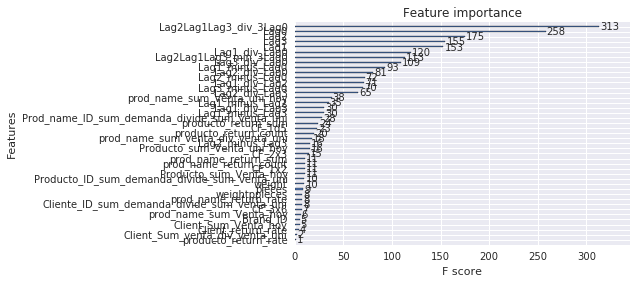

In [37]:
defaultParams = {"max_depth":6, "subsample":1., "min_child_weight":5, "colsample_bytree":0.4, "missing":np.nan
                ,"n_estimators":500, "learning_rate":0.1}
xgb_model1 = xgb.XGBRegressor(**defaultParams) 


xgb_model1.fit(X_train,y_train,eval_set=[(X_train, y_train),(X_test, y_test)],
         verbose=1, early_stopping_rounds = 10)


predictions = xgb_model1.predict(X_train,ntree_limit  = xgb_model1.best_iteration+1)
predictionsTest = xgb_model1.predict(X_test,ntree_limit  = xgb_model1.best_iteration+1)

print "trainResult: ", np.sqrt(mean_squared_error(y_train, predictions))
print "testResult: ", np.sqrt(mean_squared_error(y_test, predictionsTest))
print "Best Iteration: ", xgb_model1.best_iteration
print "Best Score: ", xgb_model1.best_score
print xgb.plot_importance(xgb_model1)

{'base_score': 0.5,
 'colsample_bylevel': 1,
 'colsample_bytree': 0.4,
 'gamma': 0,
 'learning_rate': 0.1,
 'max_delta_step': 0,
 'max_depth': 6,
 'min_child_weight': 5,
 'missing': None,
 'n_estimators': 500,
 'objective': 'reg:linear',
 'reg_alpha': 0,
 'reg_lambda': 1,
 'scale_pos_weight': 1,
 'seed': 0,
 'silent': 1,
 'subsample': 1.0}

In [ ]:
X_train = FE.train[test2columns].copy()
gc.collect()
X_test = FE.test2[test2columns].copy()
gc.collect()
y_train = FE.train["Demanda_uni_equil"]
y_test = FE.test2["Demanda_uni_equil"]
gc.collect()

In [ ]:


gc.collect()
X_train.loc[:,"Lag2_minus_Lag0"]= X_train["Lag2"].values-X_train["Lag0"].values
X_train.loc[:,"Lag3_minus_Lag0"]= X_train["Lag3"].values-X_train["Lag0"].values
X_train.loc[:,"Lag1_minus_Lag2"]= X_train["Lag1"].values-X_train["Lag2"].values
X_train.loc[:,"Lag2_minus_Lag3"]= X_train["Lag2"].values-X_train["Lag3"].values

X_train.loc[:,"Lag2_div_Lag0"]= X_train["Lag2"].values/X_train["Lag0"].values
X_train.loc[:,"Lag3_div_Lag0"]= X_train["Lag3"].values/X_train["Lag0"].values
X_train.loc[:,"Lag2_div_Lag3"]= X_train["Lag2"].values/X_train["Lag3"].values

X_train.loc[:,"Lag2Lag3_div_3Lag0"]= (X_train["Lag2"].values+X_train["Lag3"].values) / (2*X_train["Lag0"].values)
X_train.loc[:,"Lag2Lag3_min_3Lag0"]= (X_train["Lag2"].values+X_train["Lag3"].values) - (2*X_train["Lag0"].values)

X_train.loc[:,"CF_1x2"] = X_train["Client_Sum_Venta_hoy"].values * X_train["Cliente_ID_sum_demanda_divide_sum_venta_uni"].values
X_train.loc[:,"CF_3x6"] = X_train["prod_name_sum_venta_div_venta_uni"].values * X_train.loc[:,"Prod_name_ID_sum_demanda_divide_sum_venta_uni"].values

X_train.loc[:,"CF_2x3"] = X_train["Cliente_ID_sum_demanda_divide_sum_venta_uni"].values * X_train.loc[:,"prod_name_sum_venta_div_venta_uni"].values

X_train.loc[:,"CF_1d5"] = X_train["Client_Sum_Venta_hoy"].values / X_train["Client_Sum_venta_div_venta_uni"].values

gc.collect()

X_test.loc[:,"Lag2_minus_Lag0"]= X_test["Lag2"].values-X_test["Lag0"].values
X_test.loc[:,"Lag3_minus_Lag0"]= X_test["Lag3"].values-X_test["Lag0"].values
X_test.loc[:,"Lag1_minus_Lag2"]= X_test["Lag1"].values-X_test["Lag2"].values
X_test.loc[:,"Lag2_minus_Lag3"]= X_test["Lag2"].values-X_test["Lag3"].values

X_test.loc[:,"Lag2_div_Lag0"]= X_test["Lag2"].values/X_test["Lag0"].values
X_test.loc[:,"Lag3_div_Lag0"]= X_test["Lag3"].values/X_test["Lag0"].values
X_test.loc[:,"Lag2_div_Lag3"]= X_test["Lag2"].values/X_test["Lag3"].values

X_test.loc[:,"Lag2Lag3_div_3Lag0"]= (X_test["Lag2"].values+X_test["Lag3"].values) / (2*X_test["Lag0"].values)
X_test.loc[:,"Lag2Lag3_min_3Lag0"]= (X_test["Lag2"].values+X_test["Lag3"].values) - (2*X_test["Lag0"].values)

X_test.loc[:,"CF_1x2"] = X_test["Client_Sum_Venta_hoy"].values * X_test["Cliente_ID_sum_demanda_divide_sum_venta_uni"].values
X_test.loc[:,"CF_3x6"] = X_test["prod_name_sum_venta_div_venta_uni"].values * X_test.loc[:,"Prod_name_ID_sum_demanda_divide_sum_venta_uni"].values

X_test.loc[:,"CF_2x3"] = X_test["Cliente_ID_sum_demanda_divide_sum_venta_uni"].values * X_test.loc[:,"prod_name_sum_venta_div_venta_uni"].values

X_test.loc[:,"CF_1d5"] = X_test["Client_Sum_Venta_hoy"].values / X_test["Client_Sum_venta_div_venta_uni"].values
gc.collect()

X_train.replace([np.inf, -np.inf], 0,inplace=True)

In [ ]:
defaultParams = {"max_depth":6, "subsample":1., "min_child_weight":5, "colsample_bytree":0.4, "missing":np.nan
                ,"n_estimators":500, "learning_rate":0.1}
xgb_model2 = xgb.XGBRegressor(**defaultParams) 


xgb_model2.fit(X_train,y_train,eval_set=[(X_train, y_train),(X_test, y_test)],
         verbose=1, early_stopping_rounds = 10)


predictions = xgb_model2.predict(X_train,ntree_limit  = xgb_model2.best_iteration+1)
predictionsTest = xgb_model2.predict(X_test,ntree_limit  = xgb_model2.best_iteration+1)

print "trainResult: ", np.sqrt(mean_squared_error(y_train, predictions))
print "testResult: ", np.sqrt(mean_squared_error(y_test, predictionsTest))
print "Best Iteration: ", xgb_model2.best_iteration
print "Best Score: ", xgb_model2.best_score
print xgb.plot_importance(xgb_model2)

## Trial 5: removing highly correlated cf cols


In [43]:
test2columns = ['State_ID',
       'weight', 'pieces', 'Brand_ID', 'Lag0',
       'Lag2', 'Lag3', 'weightppieces', 'Client_Sum_Venta_hoy',
       'Client_Sum_Venta_uni_hoy', 'Client_Sum_venta_div_venta_uni',
       'prod_name_sum_Venta_hoy', 'prod_name_sum_Venta_uni_hoy',
       'prod_name_sum_venta_div_venta_uni', 'Producto_sum_Venta_hoy',
       'Producto_sum_Venta_uni_hoy', 'Producto_sum_venta_div_venta_uni',
       'Producto_ID_sum_demanda_divide_sum_venta_uni',
       'Prod_name_ID_sum_demanda_divide_sum_venta_uni',
       'Cliente_ID_sum_demanda_divide_sum_venta_uni', 'ClientPerTown',
       'client_return_sum', 'client_return_count', 'Client_return_rate',
       'producto_return_sum', 'producto_return_count',
       'producto_return_rate', 'prod_name_return_sum',
       'prod_name_return_count', 'prod_name_return_rate']

columns_to_remove = ['client_return_sum', 'client_return_count',
                     'Client_Sum_Venta_uni_hoy', 'Producto_sum_venta_div_venta_uni'
                    ]

test2columns = list ( set(test2columns) - set(columns_to_remove))

test1columns = test2columns + ['Lag1']

In [44]:
X_train = FE.train[test1columns].copy()
X_test = FE.test1[test1columns].copy()
y_train = FE.train["Demanda_uni_equil"]
y_test = FE.test1["Demanda_uni_equil"]
gc.collect()

16911

In [45]:


gc.collect()
X_train.loc[:,"Lag1_minus_Lag0"]= X_train["Lag1"].values-X_train["Lag0"].values
X_train.loc[:,"Lag2_minus_Lag0"]= X_train["Lag2"].values-X_train["Lag0"].values
X_train.loc[:,"Lag3_minus_Lag0"]= X_train["Lag3"].values-X_train["Lag0"].values
X_train.loc[:,"Lag1_minus_Lag2"]= X_train["Lag1"].values-X_train["Lag2"].values
X_train.loc[:,"Lag1_minus_Lag3"]= X_train["Lag1"].values-X_train["Lag3"].values
X_train.loc[:,"Lag2_minus_Lag3"]= X_train["Lag2"].values-X_train["Lag3"].values

X_train.loc[:,"Lag1_div_Lag0"]= X_train["Lag1"].values/X_train["Lag0"].values
X_train.loc[:,"Lag2_div_Lag0"]= X_train["Lag2"].values/X_train["Lag0"].values
X_train.loc[:,"Lag3_div_Lag0"]= X_train["Lag3"].values/X_train["Lag0"].values
X_train.loc[:,"Lag1_div_Lag2"]= X_train["Lag1"].values/X_train["Lag2"].values
X_train.loc[:,"Lag1_div_Lag3"]= X_train["Lag1"].values/X_train["Lag3"].values
X_train.loc[:,"Lag2_div_Lag3"]= X_train["Lag2"].values/X_train["Lag3"].values

X_train.loc[:,"Lag2Lag1Lag3_div_3Lag0"]= (X_train["Lag1"].values+X_train["Lag2"].values+X_train["Lag3"].values) / (3*X_train["Lag0"].values)
X_train.loc[:,"Lag2Lag1Lag3_min_3Lag0"]= (X_train["Lag1"].values+X_train["Lag2"].values+X_train["Lag3"].values) - (3*X_train["Lag0"].values)


X_test.loc[:,"Lag1_minus_Lag0"]= X_test["Lag1"].values-X_test["Lag0"].values
X_test.loc[:,"Lag2_minus_Lag0"]= X_test["Lag2"].values-X_test["Lag0"].values
X_test.loc[:,"Lag3_minus_Lag0"]= X_test["Lag3"].values-X_test["Lag0"].values
X_test.loc[:,"Lag1_minus_Lag2"]= X_test["Lag1"].values-X_test["Lag2"].values
X_test.loc[:,"Lag1_minus_Lag3"]= X_test["Lag1"].values-X_test["Lag3"].values
X_test.loc[:,"Lag2_minus_Lag3"]= X_test["Lag2"].values-X_test["Lag3"].values

X_test.loc[:,"Lag1_div_Lag0"]= X_test["Lag1"].values/X_test["Lag0"].values
X_test.loc[:,"Lag2_div_Lag0"]= X_test["Lag2"].values/X_test["Lag0"].values
X_test.loc[:,"Lag3_div_Lag0"]= X_test["Lag3"].values/X_test["Lag0"].values
X_test.loc[:,"Lag1_div_Lag2"]= X_test["Lag1"].values/X_test["Lag2"].values
X_test.loc[:,"Lag1_div_Lag3"]= X_test["Lag1"].values/X_test["Lag3"].values
X_test.loc[:,"Lag2_div_Lag3"]= X_test["Lag2"].values/X_test["Lag3"].values

X_test.loc[:,"Lag2Lag1Lag3_div_3Lag0"]= (X_test["Lag1"].values+X_test["Lag2"].values+X_test["Lag3"].values) / (3*X_test["Lag0"].values)
X_test.loc[:,"Lag2Lag1Lag3_min_3Lag0"]= (X_test["Lag1"].values+X_test["Lag2"].values+X_test["Lag3"].values) - (3*X_test["Lag0"].values)


In [46]:
X_train.replace([np.inf, -np.inf], 0,inplace=True)

In [36]:
X_train.describe()

,weight,Producto_sum_Venta_hoy,pieces,producto_return_sum,prod_name_sum_Venta_hoy,Producto_sum_Venta_uni_hoy,Prod_name_ID_sum_demanda_divide_sum_venta_uni,producto_return_rate,Cliente_ID_sum_demanda_divide_sum_venta_uni,Client_return_rate,...,Lag3_div_Lag0,Lag1_div_Lag2,Lag1_div_Lag3,Lag2_div_Lag3,Lag2Lag1Lag3_div_3Lag0,Lag2Lag1Lag3_min_3Lag0,CF_1x2,CF_3x6,CF_2x3,CF_1d5
count,2.057469e+07,20574686.0,2.057469e+07,2.057469e+07,20574686.0,20574686.00,2.057469e+07,2.057469e+07,2.057469e+07,2.057469e+07,...,2.056507e+07,2.055320e+07,2.055894e+07,2.055236e+07,2.057038e+07,2.057469e+07,2.057469e+07,2.057469e+07,2.057469e+07,2.057428e+07
mean,1.934881e+02,29581898.0,3.648904e+00,3.212873e+03,66873048.0,3484560.75,8.154300e-01,7.293724e-03,8.154300e-01,7.830587e-03,...,1.103212e+00,9.979233e-01,1.004406e+00,1.020036e+00,1.085077e+00,1.665871e-01,1.863554e+05,9.794215e+00,9.766045e+00,2.315232e+04
std,2.400293e+02,31973954.0,5.946356e+00,2.872591e+03,73622120.0,3955445.25,1.682588e-01,1.619270e-02,1.775564e-01,2.169856e-02,...,3.785615e-01,3.450874e-01,3.820449e-01,3.424234e-01,2.993797e-01,9.627634e-01,4.344222e+06,5.854558e+00,5.867441e+00,5.476689e+05
min,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.0,0.00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-2.249198e+01,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
25%,8.000000e+01,5743723.0,0.000000e+00,7.970000e+02,13216401.0,644591.00,9.841685e-01,3.523282e-03,9.868996e-01,0.000000e+00,...,NaN,NaN,NaN,NaN,NaN,-2.772959e-01,1.852300e+03,6.796261e+00,6.764351e+00,NaN
50%,1.200000e+02,20126136.0,2.000000e+00,2.355000e+03,50557572.0,2152268.00,9.882854e-01,5.011800e-03,9.957058e-01,0.000000e+00,...,NaN,NaN,NaN,NaN,NaN,1.021652e-01,4.305370e+03,8.498184e+00,8.464285e+00,NaN
75%,2.550000e+02,46850392.0,4.000000e+00,5.260000e+03,80465216.0,5353767.00,9.926778e-01,8.114606e-03,1.000000e+00,8.928572e-03,...,NaN,NaN,NaN,NaN,NaN,5.762972e-01,9.543668e+03,1.225382e+01,1.202919e+01,NaN
max,4.200000e+04,157880816.0,2.000000e+02,1.262400e+04,310051648.0,17735436.00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,...,2.304848e+01,4.523684e+01,8.141329e+01,4.523684e+01,1.527423e+01,2.161951e+01,1.051199e+08,6.412330e+03,6.270494e+03,1.325432e+07


In [38]:
#X_train.info()
corrDf = X_train.corr()
corrDf.to_csv('../../input/coordfX.csv')

[0]	validation_0-rmse:1.25599	validation_1-rmse:1.25864
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 10 rounds.
[1]	validation_0-rmse:1.13751	validation_1-rmse:1.14712
[2]	validation_0-rmse:1.03966	validation_1-rmse:1.05611
[3]	validation_0-rmse:0.945427	validation_1-rmse:0.970382
[4]	validation_0-rmse:0.860801	validation_1-rmse:0.896141
[5]	validation_0-rmse:0.785984	validation_1-rmse:0.830303
[6]	validation_0-rmse:0.71701	validation_1-rmse:0.77358
[7]	validation_0-rmse:0.656397	validation_1-rmse:0.725291
[8]	validation_0-rmse:0.608301	validation_1-rmse:0.687744
[9]	validation_0-rmse:0.560371	validation_1-rmse:0.653075
[10]	validation_0-rmse:0.51788	validation_1-rmse:0.623925
[11]	validation_0-rmse:0.480603	validation_1-rmse:0.600006
[12]	validation_0-rmse:0.448035	validation_1-rmse:0.581044
[13]	validation_0-rmse:0.420167	validation_1-rmse:0.56518
[14]	validation_0-rmse:0.395781	val

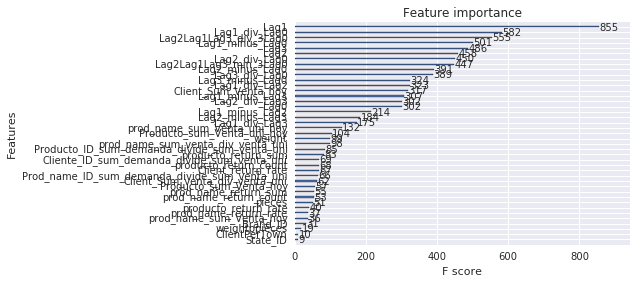

In [48]:
defaultParams = {"max_depth":6, "subsample":1., "min_child_weight":5, "colsample_bytree":0.4, "missing":np.nan
                ,"n_estimators":500, "learning_rate":0.1}
xgb_model1 = xgb.XGBRegressor(**defaultParams) 


xgb_model1.fit(X_train,y_train,eval_set=[(X_train, y_train),(X_test, y_test)],
         verbose=1, early_stopping_rounds = 10)


predictions = xgb_model1.predict(X_train,ntree_limit  = xgb_model1.best_iteration+1)
predictionsTest = xgb_model1.predict(X_test,ntree_limit  = xgb_model1.best_iteration+1)

print "trainResult: ", np.sqrt(mean_squared_error(y_train, predictions))
print "testResult: ", np.sqrt(mean_squared_error(y_test, predictionsTest))
print "Best Iteration: ", xgb_model1.best_iteration
print "Best Score: ", xgb_model1.best_score
print xgb.plot_importance(xgb_model1)

{'base_score': 0.5,
 'colsample_bylevel': 1,
 'colsample_bytree': 0.4,
 'gamma': 0,
 'learning_rate': 0.1,
 'max_delta_step': 0,
 'max_depth': 6,
 'min_child_weight': 5,
 'missing': None,
 'n_estimators': 500,
 'objective': 'reg:linear',
 'reg_alpha': 0,
 'reg_lambda': 1,
 'scale_pos_weight': 1,
 'seed': 0,
 'silent': 1,
 'subsample': 1.0}

In [ ]:
X_train = FE.train[test2columns].copy()
gc.collect()
X_test = FE.test2[test2columns].copy()
gc.collect()
y_train = FE.train["Demanda_uni_equil"]
y_test = FE.test2["Demanda_uni_equil"]
gc.collect()

In [ ]:


gc.collect()
X_train.loc[:,"Lag2_minus_Lag0"]= X_train["Lag2"].values-X_train["Lag0"].values
X_train.loc[:,"Lag3_minus_Lag0"]= X_train["Lag3"].values-X_train["Lag0"].values
X_train.loc[:,"Lag1_minus_Lag2"]= X_train["Lag1"].values-X_train["Lag2"].values
X_train.loc[:,"Lag2_minus_Lag3"]= X_train["Lag2"].values-X_train["Lag3"].values

X_train.loc[:,"Lag2_div_Lag0"]= X_train["Lag2"].values/X_train["Lag0"].values
X_train.loc[:,"Lag3_div_Lag0"]= X_train["Lag3"].values/X_train["Lag0"].values
X_train.loc[:,"Lag2_div_Lag3"]= X_train["Lag2"].values/X_train["Lag3"].values

X_train.loc[:,"Lag2Lag3_div_3Lag0"]= (X_train["Lag2"].values+X_train["Lag3"].values) / (2*X_train["Lag0"].values)
X_train.loc[:,"Lag2Lag3_min_3Lag0"]= (X_train["Lag2"].values+X_train["Lag3"].values) - (2*X_train["Lag0"].values)

gc.collect()

X_test.loc[:,"Lag2_minus_Lag0"]= X_test["Lag2"].values-X_test["Lag0"].values
X_test.loc[:,"Lag3_minus_Lag0"]= X_test["Lag3"].values-X_test["Lag0"].values
X_test.loc[:,"Lag1_minus_Lag2"]= X_test["Lag1"].values-X_test["Lag2"].values
X_test.loc[:,"Lag2_minus_Lag3"]= X_test["Lag2"].values-X_test["Lag3"].values

X_test.loc[:,"Lag2_div_Lag0"]= X_test["Lag2"].values/X_test["Lag0"].values
X_test.loc[:,"Lag3_div_Lag0"]= X_test["Lag3"].values/X_test["Lag0"].values
X_test.loc[:,"Lag2_div_Lag3"]= X_test["Lag2"].values/X_test["Lag3"].values

X_test.loc[:,"Lag2Lag3_div_3Lag0"]= (X_test["Lag2"].values+X_test["Lag3"].values) / (2*X_test["Lag0"].values)
X_test.loc[:,"Lag2Lag3_min_3Lag0"]= (X_test["Lag2"].values+X_test["Lag3"].values) - (2*X_test["Lag0"].values)

gc.collect()

X_train.replace([np.inf, -np.inf], 0,inplace=True)

In [ ]:
defaultParams = {"max_depth":6, "subsample":1., "min_child_weight":5, "colsample_bytree":0.4, "missing":np.nan
                ,"n_estimators":500, "learning_rate":0.1}
xgb_model2 = xgb.XGBRegressor(**defaultParams) 


xgb_model2.fit(X_train,y_train,eval_set=[(X_train, y_train),(X_test, y_test)],
         verbose=1, early_stopping_rounds = 10)


predictions = xgb_model2.predict(X_train,ntree_limit  = xgb_model2.best_iteration+1)
predictionsTest = xgb_model2.predict(X_test,ntree_limit  = xgb_model2.best_iteration+1)

print "trainResult: ", np.sqrt(mean_squared_error(y_train, predictions))
print "testResult: ", np.sqrt(mean_squared_error(y_test, predictionsTest))
print "Best Iteration: ", xgb_model2.best_iteration
print "Best Score: ", xgb_model2.best_score
print xgb.plot_importance(xgb_model2)

## Trial 6: replacing inf with 0/999 vs nan

In [49]:
test2columns = ['State_ID',
       'weight', 'pieces', 'Brand_ID', 'Lag0',
       'Lag2', 'Lag3', 'weightppieces', 'Client_Sum_Venta_hoy',
       'Client_Sum_Venta_uni_hoy', 'Client_Sum_venta_div_venta_uni',
       'prod_name_sum_Venta_hoy', 'prod_name_sum_Venta_uni_hoy',
       'prod_name_sum_venta_div_venta_uni', 'Producto_sum_Venta_hoy',
       'Producto_sum_Venta_uni_hoy', 'Producto_sum_venta_div_venta_uni',
       'Producto_ID_sum_demanda_divide_sum_venta_uni',
       'Prod_name_ID_sum_demanda_divide_sum_venta_uni',
       'Cliente_ID_sum_demanda_divide_sum_venta_uni', 'ClientPerTown',
       'client_return_sum', 'client_return_count', 'Client_return_rate',
       'producto_return_sum', 'producto_return_count',
       'producto_return_rate', 'prod_name_return_sum',
       'prod_name_return_count', 'prod_name_return_rate']

columns_to_remove = ['client_return_sum', 'client_return_count',
                     'Client_Sum_Venta_uni_hoy', 'Producto_sum_venta_div_venta_uni'
                    ]

test2columns = list ( set(test2columns) - set(columns_to_remove))

test1columns = test2columns + ['Lag1']

In [50]:
X_train = FE.train[test1columns].copy()
X_test = FE.test1[test1columns].copy()
y_train = FE.train["Demanda_uni_equil"]
y_test = FE.test1["Demanda_uni_equil"]
gc.collect()

34331

In [51]:


gc.collect()
X_train.loc[:,"Lag1_minus_Lag0"]= X_train["Lag1"].values-X_train["Lag0"].values
X_train.loc[:,"Lag2_minus_Lag0"]= X_train["Lag2"].values-X_train["Lag0"].values
X_train.loc[:,"Lag3_minus_Lag0"]= X_train["Lag3"].values-X_train["Lag0"].values
X_train.loc[:,"Lag1_minus_Lag2"]= X_train["Lag1"].values-X_train["Lag2"].values
X_train.loc[:,"Lag1_minus_Lag3"]= X_train["Lag1"].values-X_train["Lag3"].values
X_train.loc[:,"Lag2_minus_Lag3"]= X_train["Lag2"].values-X_train["Lag3"].values

X_train.loc[:,"Lag1_div_Lag0"]= X_train["Lag1"].values/X_train["Lag0"].values
X_train.loc[:,"Lag2_div_Lag0"]= X_train["Lag2"].values/X_train["Lag0"].values
X_train.loc[:,"Lag3_div_Lag0"]= X_train["Lag3"].values/X_train["Lag0"].values
X_train.loc[:,"Lag1_div_Lag2"]= X_train["Lag1"].values/X_train["Lag2"].values
X_train.loc[:,"Lag1_div_Lag3"]= X_train["Lag1"].values/X_train["Lag3"].values
X_train.loc[:,"Lag2_div_Lag3"]= X_train["Lag2"].values/X_train["Lag3"].values

X_train.loc[:,"Lag2Lag1Lag3_div_3Lag0"]= (X_train["Lag1"].values+X_train["Lag2"].values+X_train["Lag3"].values) / (3*X_train["Lag0"].values)
X_train.loc[:,"Lag2Lag1Lag3_min_3Lag0"]= (X_train["Lag1"].values+X_train["Lag2"].values+X_train["Lag3"].values) - (3*X_train["Lag0"].values)


X_test.loc[:,"Lag1_minus_Lag0"]= X_test["Lag1"].values-X_test["Lag0"].values
X_test.loc[:,"Lag2_minus_Lag0"]= X_test["Lag2"].values-X_test["Lag0"].values
X_test.loc[:,"Lag3_minus_Lag0"]= X_test["Lag3"].values-X_test["Lag0"].values
X_test.loc[:,"Lag1_minus_Lag2"]= X_test["Lag1"].values-X_test["Lag2"].values
X_test.loc[:,"Lag1_minus_Lag3"]= X_test["Lag1"].values-X_test["Lag3"].values
X_test.loc[:,"Lag2_minus_Lag3"]= X_test["Lag2"].values-X_test["Lag3"].values

X_test.loc[:,"Lag1_div_Lag0"]= X_test["Lag1"].values/X_test["Lag0"].values
X_test.loc[:,"Lag2_div_Lag0"]= X_test["Lag2"].values/X_test["Lag0"].values
X_test.loc[:,"Lag3_div_Lag0"]= X_test["Lag3"].values/X_test["Lag0"].values
X_test.loc[:,"Lag1_div_Lag2"]= X_test["Lag1"].values/X_test["Lag2"].values
X_test.loc[:,"Lag1_div_Lag3"]= X_test["Lag1"].values/X_test["Lag3"].values
X_test.loc[:,"Lag2_div_Lag3"]= X_test["Lag2"].values/X_test["Lag3"].values

X_test.loc[:,"Lag2Lag1Lag3_div_3Lag0"]= (X_test["Lag1"].values+X_test["Lag2"].values+X_test["Lag3"].values) / (3*X_test["Lag0"].values)
X_test.loc[:,"Lag2Lag1Lag3_min_3Lag0"]= (X_test["Lag1"].values+X_test["Lag2"].values+X_test["Lag3"].values) - (3*X_test["Lag0"].values)
X_train.replace([np.inf], 999,inplace=True)
X_train.replace([-np.inf], 0,inplace=True)

In [38]:
#X_train.info()
corrDf = X_train.corr()
corrDf.to_csv('../../input/coordfX.csv')

[0]	validation_0-rmse:1.25648	validation_1-rmse:1.25895
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 10 rounds.
[1]	validation_0-rmse:1.14003	validation_1-rmse:1.14762
[2]	validation_0-rmse:1.04372	validation_1-rmse:1.05732
[3]	validation_0-rmse:0.958727	validation_1-rmse:0.979421
[4]	validation_0-rmse:0.88505	validation_1-rmse:0.914147
[5]	validation_0-rmse:0.808896	validation_1-rmse:0.846566
[6]	validation_0-rmse:0.738246	validation_1-rmse:0.787706
[7]	validation_0-rmse:0.677944	validation_1-rmse:0.738803
[8]	validation_0-rmse:0.631309	validation_1-rmse:0.702075
[9]	validation_0-rmse:0.582289	validation_1-rmse:0.665053
[10]	validation_0-rmse:0.546713	validation_1-rmse:0.640171
[11]	validation_0-rmse:0.507379	validation_1-rmse:0.613553
[12]	validation_0-rmse:0.473734	validation_1-rmse:0.592779
[13]	validation_0-rmse:0.444723	validation_1-rmse:0.574913
[14]	validation_0-rmse:0.418984	

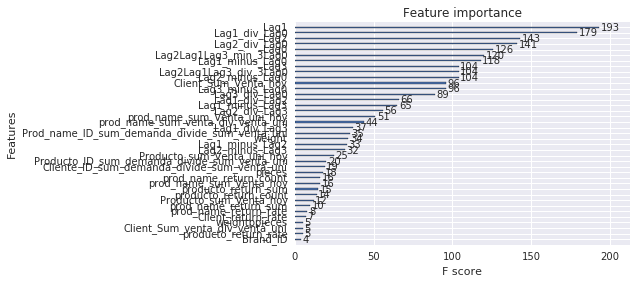

In [52]:
defaultParams = {"max_depth":6, "subsample":1., "min_child_weight":5, "colsample_bytree":0.4, "missing":np.nan
                ,"n_estimators":500, "learning_rate":0.1}
xgb_model1 = xgb.XGBRegressor(**defaultParams) 


xgb_model1.fit(X_train,y_train,eval_set=[(X_train, y_train),(X_test, y_test)],
         verbose=1, early_stopping_rounds = 10)


predictions = xgb_model1.predict(X_train,ntree_limit  = xgb_model1.best_iteration+1)
predictionsTest = xgb_model1.predict(X_test,ntree_limit  = xgb_model1.best_iteration+1)

print "trainResult: ", np.sqrt(mean_squared_error(y_train, predictions))
print "testResult: ", np.sqrt(mean_squared_error(y_test, predictionsTest))
print "Best Iteration: ", xgb_model1.best_iteration
print "Best Score: ", xgb_model1.best_score
print xgb.plot_importance(xgb_model1)

TRY NAN NOW.

In [55]:


gc.collect()
X_train.loc[:,"Lag1_minus_Lag0"]= X_train["Lag1"].values-X_train["Lag0"].values
X_train.loc[:,"Lag2_minus_Lag0"]= X_train["Lag2"].values-X_train["Lag0"].values
X_train.loc[:,"Lag3_minus_Lag0"]= X_train["Lag3"].values-X_train["Lag0"].values
X_train.loc[:,"Lag1_minus_Lag2"]= X_train["Lag1"].values-X_train["Lag2"].values
X_train.loc[:,"Lag1_minus_Lag3"]= X_train["Lag1"].values-X_train["Lag3"].values
X_train.loc[:,"Lag2_minus_Lag3"]= X_train["Lag2"].values-X_train["Lag3"].values

X_train.loc[:,"Lag1_div_Lag0"]= X_train["Lag1"].values/X_train["Lag0"].values
X_train.loc[:,"Lag2_div_Lag0"]= X_train["Lag2"].values/X_train["Lag0"].values
X_train.loc[:,"Lag3_div_Lag0"]= X_train["Lag3"].values/X_train["Lag0"].values
X_train.loc[:,"Lag1_div_Lag2"]= X_train["Lag1"].values/X_train["Lag2"].values
X_train.loc[:,"Lag1_div_Lag3"]= X_train["Lag1"].values/X_train["Lag3"].values
X_train.loc[:,"Lag2_div_Lag3"]= X_train["Lag2"].values/X_train["Lag3"].values

X_train.loc[:,"Lag2Lag1Lag3_div_3Lag0"]= (X_train["Lag1"].values+X_train["Lag2"].values+X_train["Lag3"].values) / (3*X_train["Lag0"].values)
X_train.loc[:,"Lag2Lag1Lag3_min_3Lag0"]= (X_train["Lag1"].values+X_train["Lag2"].values+X_train["Lag3"].values) - (3*X_train["Lag0"].values)


X_test.loc[:,"Lag1_minus_Lag0"]= X_test["Lag1"].values-X_test["Lag0"].values
X_test.loc[:,"Lag2_minus_Lag0"]= X_test["Lag2"].values-X_test["Lag0"].values
X_test.loc[:,"Lag3_minus_Lag0"]= X_test["Lag3"].values-X_test["Lag0"].values
X_test.loc[:,"Lag1_minus_Lag2"]= X_test["Lag1"].values-X_test["Lag2"].values
X_test.loc[:,"Lag1_minus_Lag3"]= X_test["Lag1"].values-X_test["Lag3"].values
X_test.loc[:,"Lag2_minus_Lag3"]= X_test["Lag2"].values-X_test["Lag3"].values

X_test.loc[:,"Lag1_div_Lag0"]= X_test["Lag1"].values/X_test["Lag0"].values
X_test.loc[:,"Lag2_div_Lag0"]= X_test["Lag2"].values/X_test["Lag0"].values
X_test.loc[:,"Lag3_div_Lag0"]= X_test["Lag3"].values/X_test["Lag0"].values
X_test.loc[:,"Lag1_div_Lag2"]= X_test["Lag1"].values/X_test["Lag2"].values
X_test.loc[:,"Lag1_div_Lag3"]= X_test["Lag1"].values/X_test["Lag3"].values
X_test.loc[:,"Lag2_div_Lag3"]= X_test["Lag2"].values/X_test["Lag3"].values

X_test.loc[:,"Lag2Lag1Lag3_div_3Lag0"]= (X_test["Lag1"].values+X_test["Lag2"].values+X_test["Lag3"].values) / (3*X_test["Lag0"].values)
X_test.loc[:,"Lag2Lag1Lag3_min_3Lag0"]= (X_test["Lag1"].values+X_test["Lag2"].values+X_test["Lag3"].values) - (3*X_test["Lag0"].values)
X_train.replace([np.inf], np.nan,inplace=True)
X_train.replace([-np.inf], np.nan,inplace=True)

In [38]:
#X_train.info()
corrDf = X_train.corr()
corrDf.to_csv('../../input/coordfX.csv')

[0]	validation_0-rmse:1.25647	validation_1-rmse:1.259
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 10 rounds.
[1]	validation_0-rmse:1.14001	validation_1-rmse:1.14765
[2]	validation_0-rmse:1.04373	validation_1-rmse:1.05737
[3]	validation_0-rmse:0.958706	validation_1-rmse:0.979345
[4]	validation_0-rmse:0.885043	validation_1-rmse:0.914068
[5]	validation_0-rmse:0.808911	validation_1-rmse:0.846488
[6]	validation_0-rmse:0.738263	validation_1-rmse:0.787637
[7]	validation_0-rmse:0.677957	validation_1-rmse:0.738717
[8]	validation_0-rmse:0.631364	validation_1-rmse:0.702068
[9]	validation_0-rmse:0.582352	validation_1-rmse:0.665202
[10]	validation_0-rmse:0.54676	validation_1-rmse:0.640277
[11]	validation_0-rmse:0.507403	validation_1-rmse:0.61366
[12]	validation_0-rmse:0.47376	validation_1-rmse:0.592909
[13]	validation_0-rmse:0.444752	validation_1-rmse:0.575043
[14]	validation_0-rmse:0.418975	vali

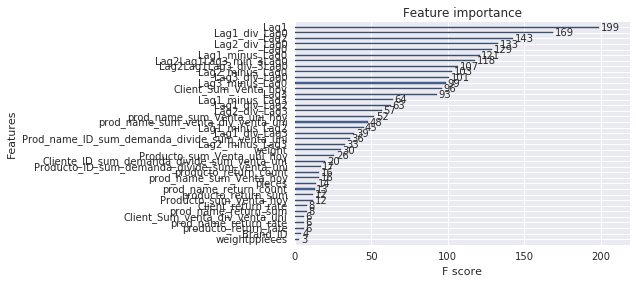

In [54]:
defaultParams = {"max_depth":6, "subsample":1., "min_child_weight":5, "colsample_bytree":0.4, "missing":np.nan
                ,"n_estimators":500, "learning_rate":0.1}
xgb_model1 = xgb.XGBRegressor(**defaultParams) 


xgb_model1.fit(X_train,y_train,eval_set=[(X_train, y_train),(X_test, y_test)],
         verbose=1, early_stopping_rounds = 10)


predictions = xgb_model1.predict(X_train,ntree_limit  = xgb_model1.best_iteration+1)
predictionsTest = xgb_model1.predict(X_test,ntree_limit  = xgb_model1.best_iteration+1)

print "trainResult: ", np.sqrt(mean_squared_error(y_train, predictions))
print "testResult: ", np.sqrt(mean_squared_error(y_test, predictionsTest))
print "Best Iteration: ", xgb_model1.best_iteration
print "Best Score: ", xgb_model1.best_score
print xgb.plot_importance(xgb_model1)

In [56]:
X_train = FE.train[test2columns].copy()
gc.collect()
X_test = FE.test2[test2columns].copy()
gc.collect()
y_train = FE.train["Demanda_uni_equil"]
y_test = FE.test2["Demanda_uni_equil"]
gc.collect()

0

In [58]:


gc.collect()
X_train.loc[:,"Lag2_minus_Lag0"]= X_train["Lag2"].values-X_train["Lag0"].values
X_train.loc[:,"Lag3_minus_Lag0"]= X_train["Lag3"].values-X_train["Lag0"].values
X_train.loc[:,"Lag2_minus_Lag3"]= X_train["Lag2"].values-X_train["Lag3"].values

X_train.loc[:,"Lag2_div_Lag0"]= X_train["Lag2"].values/X_train["Lag0"].values
X_train.loc[:,"Lag3_div_Lag0"]= X_train["Lag3"].values/X_train["Lag0"].values
X_train.loc[:,"Lag2_div_Lag3"]= X_train["Lag2"].values/X_train["Lag3"].values

X_train.loc[:,"Lag2Lag3_div_3Lag0"]= (X_train["Lag2"].values+X_train["Lag3"].values) / (2*X_train["Lag0"].values)
X_train.loc[:,"Lag2Lag3_min_3Lag0"]= (X_train["Lag2"].values+X_train["Lag3"].values) - (2*X_train["Lag0"].values)


gc.collect()

X_test.loc[:,"Lag2_minus_Lag0"]= X_test["Lag2"].values-X_test["Lag0"].values
X_test.loc[:,"Lag3_minus_Lag0"]= X_test["Lag3"].values-X_test["Lag0"].values
X_test.loc[:,"Lag2_minus_Lag3"]= X_test["Lag2"].values-X_test["Lag3"].values

X_test.loc[:,"Lag2_div_Lag0"]= X_test["Lag2"].values/X_test["Lag0"].values
X_test.loc[:,"Lag3_div_Lag0"]= X_test["Lag3"].values/X_test["Lag0"].values
X_test.loc[:,"Lag2_div_Lag3"]= X_test["Lag2"].values/X_test["Lag3"].values

X_test.loc[:,"Lag2Lag3_div_3Lag0"]= (X_test["Lag2"].values+X_test["Lag3"].values) / (2*X_test["Lag0"].values)
X_test.loc[:,"Lag2Lag3_min_3Lag0"]= (X_test["Lag2"].values+X_test["Lag3"].values) - (2*X_test["Lag0"].values)
gc.collect()

X_train.replace([np.inf], np.nan,inplace=True)
X_train.replace([-np.inf], np.nan,inplace=True)

[0]	validation_0-rmse:1.25653	validation_1-rmse:1.25347
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 10 rounds.
[1]	validation_0-rmse:1.14217	validation_1-rmse:1.14534
[2]	validation_0-rmse:1.0363	validation_1-rmse:1.04749
[3]	validation_0-rmse:0.956623	validation_1-rmse:0.974079
[4]	validation_0-rmse:0.884776	validation_1-rmse:0.9105
[5]	validation_0-rmse:0.807023	validation_1-rmse:0.843224
[6]	validation_0-rmse:0.739699	validation_1-rmse:0.786014
[7]	validation_0-rmse:0.682392	validation_1-rmse:0.738862
[8]	validation_0-rmse:0.629509	validation_1-rmse:0.697284
[9]	validation_0-rmse:0.590915	validation_1-rmse:0.668964
[10]	validation_0-rmse:0.554862	validation_1-rmse:0.641328
[11]	validation_0-rmse:0.517424	validation_1-rmse:0.615819
[12]	validation_0-rmse:0.484255	validation_1-rmse:0.59475
[13]	validation_0-rmse:0.454898	validation_1-rmse:0.577656
[14]	validation_0-rmse:0.434359	val

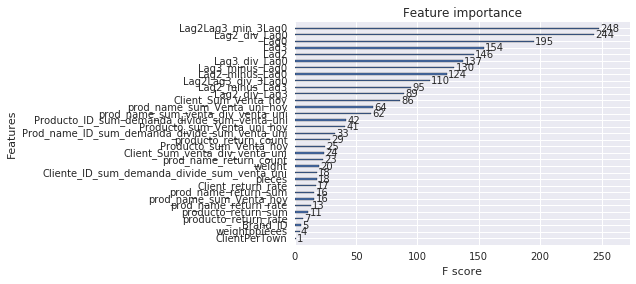

In [59]:
defaultParams = {"max_depth":6, "subsample":1., "min_child_weight":5, "colsample_bytree":0.4, "missing":np.nan
                ,"n_estimators":500, "learning_rate":0.1}
xgb_model2 = xgb.XGBRegressor(**defaultParams) 


xgb_model2.fit(X_train,y_train,eval_set=[(X_train, y_train),(X_test, y_test)],
         verbose=1, early_stopping_rounds = 10)


predictions = xgb_model2.predict(X_train,ntree_limit  = xgb_model2.best_iteration+1)
predictionsTest = xgb_model2.predict(X_test,ntree_limit  = xgb_model2.best_iteration+1)

print "trainResult: ", np.sqrt(mean_squared_error(y_train, predictions))
print "testResult: ", np.sqrt(mean_squared_error(y_test, predictionsTest))
print "Best Iteration: ", xgb_model2.best_iteration
print "Best Score: ", xgb_model2.best_score
print xgb.plot_importance(xgb_model2)

## Trial 7: removing low importance features

In [89]:
test2columns = ['State_ID',
       'weight', 'pieces', 'Brand_ID', 'Lag0',
       'Lag2', 'Lag3', 'weightppieces', 'Client_Sum_Venta_hoy',
       'Client_Sum_Venta_uni_hoy', 'Client_Sum_venta_div_venta_uni',
       'prod_name_sum_Venta_hoy', 'prod_name_sum_Venta_uni_hoy',
       'prod_name_sum_venta_div_venta_uni', 'Producto_sum_Venta_hoy',
       'Producto_sum_Venta_uni_hoy', 'Producto_sum_venta_div_venta_uni',
       'Producto_ID_sum_demanda_divide_sum_venta_uni',
       'Prod_name_ID_sum_demanda_divide_sum_venta_uni',
       'Cliente_ID_sum_demanda_divide_sum_venta_uni', 'ClientPerTown',
       'client_return_sum', 'client_return_count', 'Client_return_rate',
       'producto_return_sum', 'producto_return_count',
       'producto_return_rate', 'prod_name_return_sum',
       'prod_name_return_count', 'prod_name_return_rate']

columns_to_remove = ['client_return_sum', 'client_return_count',
                     'Client_Sum_Venta_uni_hoy', 'Producto_sum_venta_div_venta_uni',
                     'Brand_ID','State_ID', 'weightppieces', 'prod_name_return_rate',
                     'ClientPerTown' , 'prod_name_return_count', 'pieces', 'Client_Sum_venta_div_venta_uni'
                    ]

test2columns = list ( set(test2columns) - set(columns_to_remove))

test1columns = test2columns + ['Lag1']

In [90]:
X_train = FE.train[test1columns].copy()
X_test = FE.test1[test1columns].copy()
y_train = FE.train["Demanda_uni_equil"]
y_test = FE.test1["Demanda_uni_equil"]
gc.collect()

52

In [85]:


gc.collect()
#X_train.loc[:,"Lag1_minus_Lag0"]= X_train["Lag1"].values-X_train["Lag0"].values
#X_train.loc[:,"Lag2_minus_Lag0"]= X_train["Lag2"].values-X_train["Lag0"].values
#X_train.loc[:,"Lag3_minus_Lag0"]= X_train["Lag3"].values-X_train["Lag0"].values
#X_train.loc[:,"Lag1_minus_Lag2"]= X_train["Lag1"].values-X_train["Lag2"].values
#X_train.loc[:,"Lag1_minus_Lag3"]= X_train["Lag1"].values-X_train["Lag3"].values
#X_train.loc[:,"Lag2_minus_Lag3"]= X_train["Lag2"].values-X_train["Lag3"].values

#X_train.loc[:,"Lag1_div_Lag0"]= X_train["Lag1"].values/X_train["Lag0"].values
#X_train.loc[:,"Lag2_div_Lag0"]= X_train["Lag2"].values/X_train["Lag0"].values
#X_train.loc[:,"Lag3_div_Lag0"]= X_train["Lag3"].values/X_train["Lag0"].values
#X_train.loc[:,"Lag1_div_Lag2"]= X_train["Lag1"].values/X_train["Lag2"].values
#X_train.loc[:,"Lag1_div_Lag3"]= X_train["Lag1"].values/X_train["Lag3"].values
#X_train.loc[:,"Lag2_div_Lag3"]= X_train["Lag2"].values/X_train["Lag3"].values

#X_train.loc[:,"Lag2Lag1Lag3_div_3Lag0"]= (X_train["Lag1"].values+X_train["Lag2"].values+X_train["Lag3"].values) / (3*X_train["Lag0"].values)
#X_train.loc[:,"Lag2Lag1Lag3_min_3Lag0"]= (X_train["Lag1"].values+X_train["Lag2"].values+X_train["Lag3"].values) - (3*X_train["Lag0"].values)


#X_test.loc[:,"Lag1_minus_Lag0"]= X_test["Lag1"].values-X_test["Lag0"].values
#X_test.loc[:,"Lag2_minus_Lag0"]= X_test["Lag2"].values-X_test["Lag0"].values
#X_test.loc[:,"Lag3_minus_Lag0"]= X_test["Lag3"].values-X_test["Lag0"].values
#X_test.loc[:,"Lag1_minus_Lag2"]= X_test["Lag1"].values-X_test["Lag2"].values
#X_test.loc[:,"Lag1_minus_Lag3"]= X_test["Lag1"].values-X_test["Lag3"].values
#X_test.loc[:,"Lag2_minus_Lag3"]= X_test["Lag2"].values-X_test["Lag3"].values

#X_test.loc[:,"Lag1_div_Lag0"]= X_test["Lag1"].values/X_test["Lag0"].values
#X_test.loc[:,"Lag2_div_Lag0"]= X_test["Lag2"].values/X_test["Lag0"].values
#X_test.loc[:,"Lag3_div_Lag0"]= X_test["Lag3"].values/X_test["Lag0"].values
#X_test.loc[:,"Lag1_div_Lag2"]= X_test["Lag1"].values/X_test["Lag2"].values
#X_test.loc[:,"Lag1_div_Lag3"]= X_test["Lag1"].values/X_test["Lag3"].values
#X_test.loc[:,"Lag2_div_Lag3"]= X_test["Lag2"].values/X_test["Lag3"].values

#X_test.loc[:,"Lag2Lag1Lag3_div_3Lag0"]= (X_test["Lag1"].values+X_test["Lag2"].values+X_test["Lag3"].values) / (3*X_test["Lag0"].values)
#X_test.loc[:,"Lag2Lag1Lag3_min_3Lag0"]= (X_test["Lag1"].values+X_test["Lag2"].values+X_test["Lag3"].values) - (3*X_test["Lag0"].values)
#X_train.replace([np.inf], np.nan,inplace=True)
#X_train.replace([-np.inf], np.nan,inplace=True)

[0]	validation_0-rmse:1.25663	validation_1-rmse:1.25892
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 10 rounds.
[1]	validation_0-rmse:1.15237	validation_1-rmse:1.15587
[2]	validation_0-rmse:1.05861	validation_1-rmse:1.06487
[3]	validation_0-rmse:0.974058	validation_1-rmse:0.980993
[4]	validation_0-rmse:0.902247	validation_1-rmse:0.910418
[5]	validation_0-rmse:0.837722	validation_1-rmse:0.848037
[6]	validation_0-rmse:0.780335	validation_1-rmse:0.791615
[7]	validation_0-rmse:0.718137	validation_1-rmse:0.737572
[8]	validation_0-rmse:0.675206	validation_1-rmse:0.697148
[9]	validation_0-rmse:0.63749	validation_1-rmse:0.66133
[10]	validation_0-rmse:0.610239	validation_1-rmse:0.635558
[11]	validation_0-rmse:0.570409	validation_1-rmse:0.605011
[12]	validation_0-rmse:0.533709	validation_1-rmse:0.580428
[13]	validation_0-rmse:0.513545	validation_1-rmse:0.562793
[14]	validation_0-rmse:0.495812	v

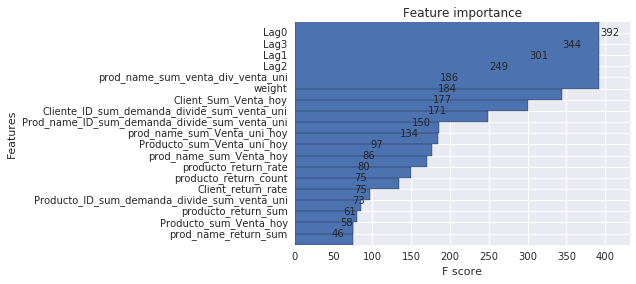

In [91]:
defaultParams = {"max_depth":6, "subsample":1., "min_child_weight":5, "colsample_bytree":0.4, "missing":np.nan
                ,"n_estimators":500, "learning_rate":0.1}
xgb_model1 = xgb.XGBRegressor(**defaultParams) 


xgb_model1.fit(X_train,y_train,eval_set=[(X_train, y_train),(X_test, y_test)],
         verbose=1, early_stopping_rounds = 10)


predictions = xgb_model1.predict(X_train,ntree_limit  = xgb_model1.best_iteration+1)
predictionsTest = xgb_model1.predict(X_test,ntree_limit  = xgb_model1.best_iteration+1)

print "trainResult: ", np.sqrt(mean_squared_error(y_train, predictions))
print "testResult: ", np.sqrt(mean_squared_error(y_test, predictionsTest))
print "Best Iteration: ", xgb_model1.best_iteration
print "Best Score: ", xgb_model1.best_score
print xgb.plot_importance(xgb_model1, height = 10)

In [92]:
X_train = FE.train[test2columns].copy()
gc.collect()
X_test = FE.test2[test2columns].copy()
gc.collect()
y_train = FE.train["Demanda_uni_equil"]
y_test = FE.test2["Demanda_uni_equil"]
gc.collect()

0

In [93]:


gc.collect()
#X_train.loc[:,"Lag2_minus_Lag0"]= X_train["Lag2"].values-X_train["Lag0"].values
#X_train.loc[:,"Lag3_minus_Lag0"]= X_train["Lag3"].values-X_train["Lag0"].values
#X_train.loc[:,"Lag2_minus_Lag3"]= X_train["Lag2"].values-X_train["Lag3"].values

#X_train.loc[:,"Lag2_div_Lag0"]= X_train["Lag2"].values/X_train["Lag0"].values
#X_train.loc[:,"Lag3_div_Lag0"]= X_train["Lag3"].values/X_train["Lag0"].values
#X_train.loc[:,"Lag2_div_Lag3"]= X_train["Lag2"].values/X_train["Lag3"].values

#X_train.loc[:,"Lag2Lag3_div_3Lag0"]= (X_train["Lag2"].values+X_train["Lag3"].values) / (2*X_train["Lag0"].values)
#X_train.loc[:,"Lag2Lag3_min_3Lag0"]= (X_train["Lag2"].values+X_train["Lag3"].values) - (2*X_train["Lag0"].values)


#gc.collect()

#X_test.loc[:,"Lag2_minus_Lag0"]= X_test["Lag2"].values-X_test["Lag0"].values
#X_test.loc[:,"Lag3_minus_Lag0"]= X_test["Lag3"].values-X_test["Lag0"].values
#X_test.loc[:,"Lag2_minus_Lag3"]= X_test["Lag2"].values-X_test["Lag3"].values

#X_test.loc[:,"Lag2_div_Lag0"]= X_test["Lag2"].values/X_test["Lag0"].values
#X_test.loc[:,"Lag3_div_Lag0"]= X_test["Lag3"].values/X_test["Lag0"].values
#X_test.loc[:,"Lag2_div_Lag3"]= X_test["Lag2"].values/X_test["Lag3"].values

#X_test.loc[:,"Lag2Lag3_div_3Lag0"]= (X_test["Lag2"].values+X_test["Lag3"].values) / (2*X_test["Lag0"].values)
#X_test.loc[:,"Lag2Lag3_min_3Lag0"]= (X_test["Lag2"].values+X_test["Lag3"].values) - (2*X_test["Lag0"].values)
gc.collect()

#X_train.replace([np.inf], np.nan,inplace=True)
#X_train.replace([-np.inf], np.nan,inplace=True)

0

[0]	validation_0-rmse:1.25701	validation_1-rmse:1.25392
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 10 rounds.
[1]	validation_0-rmse:1.15278	validation_1-rmse:1.15342
[2]	validation_0-rmse:1.05991	validation_1-rmse:1.0637
[3]	validation_0-rmse:0.977413	validation_1-rmse:0.982813
[4]	validation_0-rmse:0.904024	validation_1-rmse:0.911506
[5]	validation_0-rmse:0.849121	validation_1-rmse:0.858095
[6]	validation_0-rmse:0.776809	validation_1-rmse:0.795699
[7]	validation_0-rmse:0.713912	validation_1-rmse:0.742799
[8]	validation_0-rmse:0.669549	validation_1-rmse:0.701942
[9]	validation_0-rmse:0.63132	validation_1-rmse:0.667049
[10]	validation_0-rmse:0.598439	validation_1-rmse:0.637226
[11]	validation_0-rmse:0.57106	validation_1-rmse:0.612831
[12]	validation_0-rmse:0.533351	validation_1-rmse:0.588198
[13]	validation_0-rmse:0.500615	validation_1-rmse:0.568163
[14]	validation_0-rmse:0.48311	val

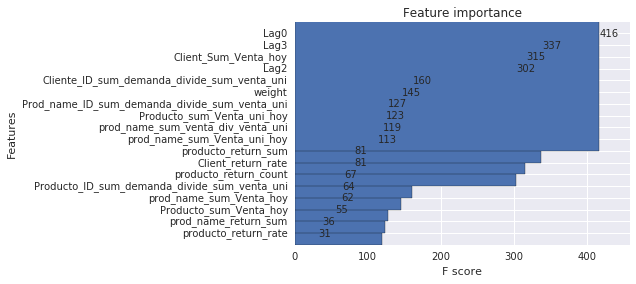

In [94]:
defaultParams = {"max_depth":6, "subsample":1., "min_child_weight":5, "colsample_bytree":0.4, "missing":np.nan
                ,"n_estimators":500, "learning_rate":0.1}
xgb_model2 = xgb.XGBRegressor(**defaultParams) 


xgb_model2.fit(X_train,y_train,eval_set=[(X_train, y_train),(X_test, y_test)],
         verbose=1, early_stopping_rounds = 10)


predictions = xgb_model2.predict(X_train,ntree_limit  = xgb_model2.best_iteration+1)
predictionsTest = xgb_model2.predict(X_test,ntree_limit  = xgb_model2.best_iteration+1)

print "trainResult: ", np.sqrt(mean_squared_error(y_train, predictions))
print "testResult: ", np.sqrt(mean_squared_error(y_test, predictionsTest))
print "Best Iteration: ", xgb_model2.best_iteration
print "Best Score: ", xgb_model2.best_score
print xgb.plot_importance(xgb_model2, height = 20)

## Trial 8: Reverting back to basics.

In [232]:
test2columns = ['State_ID',
       'weight', 'pieces', 'Brand_ID', 'Lag0',
       'Lag2', 'Lag3', 'weightppieces', 'Client_Sum_Venta_hoy',
       'Client_Sum_Venta_uni_hoy', 'Client_Sum_venta_div_venta_uni',
       'prod_name_sum_Venta_hoy', 'prod_name_sum_Venta_uni_hoy',
       'prod_name_sum_venta_div_venta_uni', 'Producto_sum_Venta_hoy',
       'Producto_sum_Venta_uni_hoy', 'Producto_sum_venta_div_venta_uni',
       'Producto_ID_sum_demanda_divide_sum_venta_uni',
       'Prod_name_ID_sum_demanda_divide_sum_venta_uni',
       'Cliente_ID_sum_demanda_divide_sum_venta_uni', 'ClientPerTown',
       'client_return_sum', 'client_return_count', 'Client_return_rate',
       'producto_return_sum', 'producto_return_count',
       'producto_return_rate', 'prod_name_return_sum',
       'prod_name_return_count', 'prod_name_return_rate']

columns_to_remove = ['client_return_sum', 'client_return_count',
                     'Client_Sum_Venta_uni_hoy', 'Producto_sum_venta_div_venta_uni'
                    ]

test2columns = list ( set(test2columns) - set(columns_to_remove))

test1columns = test2columns + ['Lag1']

In [233]:
X_train = FE.train[test1columns]
X_test = FE.test1[test1columns]
y_train = FE.train["Demanda_uni_equil"]
y_test = FE.test1["Demanda_uni_equil"]

In [ ]:
#X_train.info()
#corrDf = X_train.corr()
#corrDf.to_csv('../../input/coordf1.csv')

In [ ]:
#corrDf = X_train.corr(method = "spearman")
#corrDf.to_csv('../../input/coordf2.csv')

In [ ]:




#X_train.loc[:,"Lag2Lag1Lag3_div_3Lag0"]= (X_train["Lag1"].values+X_train["Lag2"].values+X_train["Lag3"].values) / (3*X_train["Lag0"].values)
#X_train.loc[:,"Lag2Lag1Lag3_min_3Lag0"]= ((X_train["Lag1"].values+
 #   X_train["Lag2"].values+X_train["Lag3"].values)/3) - (X_train["Lag0"].values)




#X_test.loc[:,"Lag2Lag1Lag3_min_3Lag0"]= ((X_test["Lag1"].values+
 #   X_test["Lag2"].values+X_test["Lag3"].values)/3) - (X_test["Lag0"].values)

In [ ]:
gc.collect()

[0]	validation_0-rmse:1.3224	validation_1-rmse:1.32188
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 16 rounds.
[2]	validation_0-rmse:1.21564	validation_1-rmse:1.21598
[4]	validation_0-rmse:1.11553	validation_1-rmse:1.11942
[6]	validation_0-rmse:1.01948	validation_1-rmse:1.02853
[8]	validation_0-rmse:0.943404	validation_1-rmse:0.95406
[10]	validation_0-rmse:0.871313	validation_1-rmse:0.88554
[12]	validation_0-rmse:0.809269	validation_1-rmse:0.826137
[14]	validation_0-rmse:0.756461	validation_1-rmse:0.775554
[16]	validation_0-rmse:0.700328	validation_1-rmse:0.726477
[18]	validation_0-rmse:0.659252	validation_1-rmse:0.688172
[20]	validation_0-rmse:0.620812	validation_1-rmse:0.653053
[22]	validation_0-rmse:0.586205	validation_1-rmse:0.622264
[24]	validation_0-rmse:0.557827	validation_1-rmse:0.597058
[26]	validation_0-rmse:0.532842	validation_1-rmse:0.574867
[28]	validation_0-rmse:0.496761

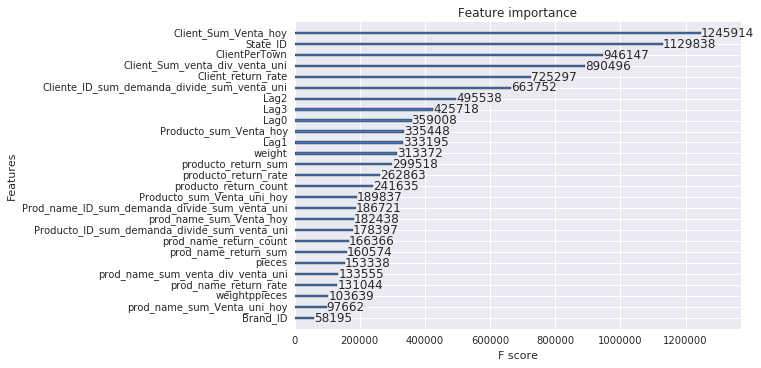

In [234]:
defaultParams = {"max_depth":20, "subsample":1., "min_child_weight":7, "colsample_bytree":0.4, "missing":np.nan
                ,"n_estimators":500, "learning_rate":0.05}
xgb_model1 = xgb.XGBRegressor(**defaultParams) 


xgb_model1.fit(X_train,y_train,eval_set=[(X_train, y_train),(X_test, y_test)],
         verbose=2, early_stopping_rounds = 16)


predictions = xgb_model1.predict(X_train,ntree_limit  = xgb_model1.best_iteration+1)
predictionsTest = xgb_model1.predict(X_test,ntree_limit  = xgb_model1.best_iteration+1)

print "trainResult: ", np.sqrt(mean_squared_error(y_train, predictions))
print "testResult: ", np.sqrt(mean_squared_error(y_test, predictionsTest))
print "Best Iteration: ", xgb_model1.best_iteration
print "Best Score: ", xgb_model1.best_score
print xgb.plot_importance(xgb_model1)

In [54]:
#corrDf = X_train.corr()
#corrDf.to_csv('../../input/coordfXX.csv')

In [ ]:
X_train = FE.train[test2columns]
X_test = FE.test2[test2columns]
y_train = FE.train["Demanda_uni_equil"]
y_test = FE.test2["Demanda_uni_equil"]

In [ ]:
defaultParams = {"max_depth":20, "subsample":1., "min_child_weight":7, "colsample_bytree":0.4, "missing":np.nan
                ,"n_estimators":500, "learning_rate":0.05}
xgb_model2 = xgb.XGBRegressor(**defaultParams) 


xgb_model2.fit(X_train,y_train,eval_set=[(X_train, y_train),(X_test, y_test)],
         verbose=1, early_stopping_rounds = 16)


predictions = xgb_model2.predict(X_train,ntree_limit  = xgb_model2.best_iteration+1)
predictionsTest = xgb_model2.predict(X_test,ntree_limit  = xgb_model2.best_iteration+1)

print "trainResult: ", np.sqrt(mean_squared_error(y_train, predictions))
print "testResult: ", np.sqrt(mean_squared_error(y_test, predictionsTest))
print "Best Iteration: ", xgb_model2.best_iteration
print "Best Score: ", xgb_model2.best_score
print xgb.plot_importance(xgb_model2)

[0]	validation_0-rmse:1.3224	validation_1-rmse:1.31632
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 16 rounds.
[1]	validation_0-rmse:1.26001	validation_1-rmse:1.25703
[2]	validation_0-rmse:1.20643	validation_1-rmse:1.2053
[3]	validation_0-rmse:1.15572	validation_1-rmse:1.15595
[4]	validation_0-rmse:1.11245	validation_1-rmse:1.11333
[5]	validation_0-rmse:1.06131	validation_1-rmse:1.06587
[6]	validation_0-rmse:1.01861	validation_1-rmse:1.02527
[7]	validation_0-rmse:0.977558	validation_1-rmse:0.9861
[8]	validation_0-rmse:0.933781	validation_1-rmse:0.946602
[9]	validation_0-rmse:0.901956	validation_1-rmse:0.915991
[10]	validation_0-rmse:0.861856	validation_1-rmse:0.880799
[11]	validation_0-rmse:0.824545	validation_1-rmse:0.848208
[12]	validation_0-rmse:0.793834	validation_1-rmse:0.819804


In [ ]:
print("Pickling sklearn API models 1")
# must open in binary format to pickle
pickle.dump(xgb_model1, open("../../input/LastShot.pkl", "wb"))
print("Pickling sklearn API models 2")
# must open in binary format to pickle
pickle.dump(xgb_model2, open("../../input/LastShot2.pkl", "wb"))

## Trial 9: Adding Client Type.

In [194]:
test2columns = ['Cliente_ID', 'State_ID',
       'weight', 'pieces', 'Brand_ID', 'Lag0',
       'Lag2', 'Lag3', 'weightppieces', 'Client_Sum_Venta_hoy',
       'Client_Sum_Venta_uni_hoy', 'Client_Sum_venta_div_venta_uni',
       'prod_name_sum_Venta_hoy', 'prod_name_sum_Venta_uni_hoy',
       'prod_name_sum_venta_div_venta_uni', 'Producto_sum_Venta_hoy',
       'Producto_sum_Venta_uni_hoy', 'Producto_sum_venta_div_venta_uni',
       'Producto_ID_sum_demanda_divide_sum_venta_uni',
       'Prod_name_ID_sum_demanda_divide_sum_venta_uni',
       'Cliente_ID_sum_demanda_divide_sum_venta_uni', 'ClientPerTown',
       'client_return_sum', 'client_return_count', 'Client_return_rate',
       'producto_return_sum', 'producto_return_count',
       'producto_return_rate', 'prod_name_return_sum',
       'prod_name_return_count', 'prod_name_return_rate']

columns_to_remove = ['client_return_sum', 'client_return_count',
                     'Client_Sum_Venta_uni_hoy', 'Producto_sum_venta_div_venta_uni',
                     'ClientPerTown' ,'Brand_ID','State_ID','prod_name_return_rate','producto_return_rate',
                     'prod_name_return_sum','prod_name_return_sum','pieces','weightppieces',
                     'Producto_sum_Venta_hoy','producto_return_count'
                    ]

test2columns = list ( set(test2columns) - set(columns_to_remove))

test1columns = test2columns + ['Lag1']

In [195]:
X_train = FE.train[test1columns]
X_test = FE.test1[test1columns]
y_train = FE.train["Demanda_uni_equil"]
y_test = FE.test1["Demanda_uni_equil"]

In [196]:
clienttype_features = pd.read_csv('../../input/clienttype_features.csv')

In [197]:
X_train.shape

(20574686, 18)

In [198]:
X_train = X_train.merge(clienttype_features, how='left', on='Cliente_ID')
X_test = X_test.merge(clienttype_features, how='left', on='Cliente_ID')

In [199]:
gc.collect()

29290

[0]	validation_0-rmse:1.25701	validation_1-rmse:1.25908
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 10 rounds.
[1]	validation_0-rmse:1.13924	validation_1-rmse:1.14732
[2]	validation_0-rmse:1.04588	validation_1-rmse:1.05499
[3]	validation_0-rmse:0.950561	validation_1-rmse:0.96751
[4]	validation_0-rmse:0.877089	validation_1-rmse:0.898061
[5]	validation_0-rmse:0.800943	validation_1-rmse:0.830501
[6]	validation_0-rmse:0.749351	validation_1-rmse:0.782162
[7]	validation_0-rmse:0.697959	validation_1-rmse:0.73502
[8]	validation_0-rmse:0.6426	validation_1-rmse:0.690009
[9]	validation_0-rmse:0.602521	validation_1-rmse:0.65418
[10]	validation_0-rmse:0.568521	validation_1-rmse:0.624578
[11]	validation_0-rmse:0.53892	validation_1-rmse:0.598934
[12]	validation_0-rmse:0.504074	validation_1-rmse:0.57535
[13]	validation_0-rmse:0.482038	validation_1-rmse:0.55718
[14]	validation_0-rmse:0.464144	validat

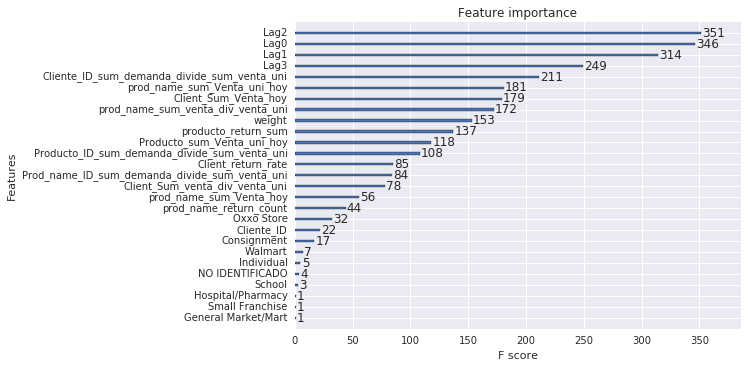

In [200]:
defaultParams = {"max_depth":6, "subsample":1., "min_child_weight":5, "colsample_bytree":0.4, "missing":np.nan
                ,"n_estimators":500, "learning_rate":0.1}
xgb_model1 = xgb.XGBRegressor(**defaultParams) 


xgb_model1.fit(X_train,y_train,eval_set=[(X_train, y_train),(X_test, y_test)],
         verbose=1, early_stopping_rounds = 10)


predictions = xgb_model1.predict(X_train,ntree_limit  = xgb_model1.best_iteration+1)
predictionsTest = xgb_model1.predict(X_test,ntree_limit  = xgb_model1.best_iteration+1)

print "trainResult: ", np.sqrt(mean_squared_error(y_train, predictions))
print "testResult: ", np.sqrt(mean_squared_error(y_test, predictionsTest))
print "Best Iteration: ", xgb_model1.best_iteration
print "Best Score: ", xgb_model1.best_score
print xgb.plot_importance(xgb_model1)

In [201]:
X_train = FE.train[test2columns]
X_test = FE.test2[test2columns]
y_train = FE.train["Demanda_uni_equil"]
y_test = FE.test2["Demanda_uni_equil"]

In [202]:
X_train = X_train.merge(clienttype_features, how='left', on='Cliente_ID')
X_test = X_test.merge(clienttype_features, how='left', on='Cliente_ID')

[0]	validation_0-rmse:1.25701	validation_1-rmse:1.25389
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 10 rounds.
[1]	validation_0-rmse:1.16499	validation_1-rmse:1.16326
[2]	validation_0-rmse:1.0752	validation_1-rmse:1.07571
[3]	validation_0-rmse:1.00436	validation_1-rmse:1.00608
[4]	validation_0-rmse:0.941315	validation_1-rmse:0.944847
[5]	validation_0-rmse:0.873268	validation_1-rmse:0.880122
[6]	validation_0-rmse:0.79824	validation_1-rmse:0.814684
[7]	validation_0-rmse:0.731679	validation_1-rmse:0.758489
[8]	validation_0-rmse:0.672923	validation_1-rmse:0.710716
[9]	validation_0-rmse:0.631512	validation_1-rmse:0.673822
[10]	validation_0-rmse:0.585167	validation_1-rmse:0.639561
[11]	validation_0-rmse:0.554873	validation_1-rmse:0.613644
[12]	validation_0-rmse:0.518193	validation_1-rmse:0.589539
[13]	validation_0-rmse:0.495491	validation_1-rmse:0.571175
[14]	validation_0-rmse:0.467234	val

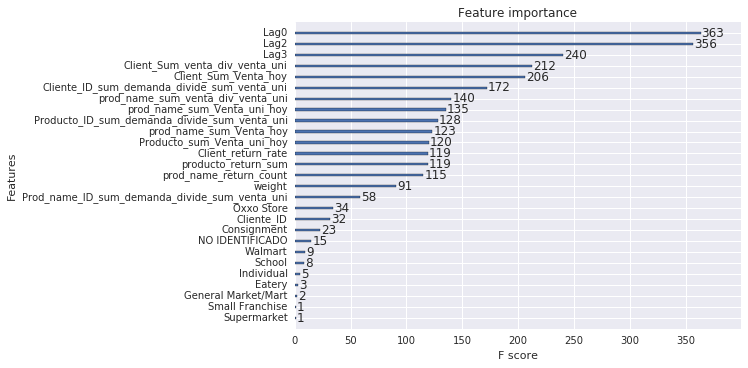

In [203]:
defaultParams = {"max_depth":6, "subsample":1., "min_child_weight":5, "colsample_bytree":0.4, "missing":np.nan
                ,"n_estimators":500, "learning_rate":0.1}
xgb_model2 = xgb.XGBRegressor(**defaultParams) 


xgb_model2.fit(X_train,y_train,eval_set=[(X_train, y_train),(X_test, y_test)],
         verbose=1, early_stopping_rounds = 10)


predictions = xgb_model2.predict(X_train,ntree_limit  = xgb_model2.best_iteration+1)
predictionsTest = xgb_model2.predict(X_test,ntree_limit  = xgb_model2.best_iteration+1)

print "trainResult: ", np.sqrt(mean_squared_error(y_train, predictions))
print "testResult: ", np.sqrt(mean_squared_error(y_test, predictionsTest))
print "Best Iteration: ", xgb_model2.best_iteration
print "Best Score: ", xgb_model2.best_score
print xgb.plot_importance(xgb_model2)

In [229]:
def GiveBestParameterWithoutCV(defaultParams, testParams, X_train, X_test, Y_train, Y_test, fitParams):
    xgb_model = xgb.XGBRegressor(**defaultParams) 
    
    minRmse = 10000
    minRmseParameter = 10000
    bestIteration = 1000
        
    for key,values in testParams:
        minRmseParameter = xgb_model.get_xgb_params()[key]
        print 'Trying this parameter: {}'.format(key)
        for value in values:
            print ('Trying this {} value for this {} parameter:').format(value,key)
            xgb_model.set_params(**{key:value})
            xgb_model.fit(X_train,Y_train, eval_set=[(X_train, Y_train),(X_test, Y_test)],
                  **fitParams)
            if xgb_model.best_score < minRmse:
                minRmse = xgb_model.best_score
                minRmseParameter = value
                bestIteration = xgb_model.best_iteration
                
        xgb_model.set_params(**{key:minRmseParameter})
        print "Parameters are finished for {}. Best Iteration is {}".format(key, bestIteration)
        print "Minimum Rmse : {}, optimum parameter is {} between {}".format(minRmse, minRmseParameter, values)
    gc.collect()

In [231]:
defaultParams = {"max_depth":14, "subsample":1., "min_child_weight":7, "colsample_bytree":0.4, "missing":np.nan
                ,"n_estimators":500, "learning_rate":0.05}
testParams = [("max_depth",[18]),
                  ("colsample_bytree",[0.5,0.6,0.7]), ("learning_rate",[0.01])]
fitParams = {"verbose":5, "early_stopping_rounds": 16}

GiveBestParameterWithoutCV(defaultParams,testParams, X_train, X_test, y_train, y_test, fitParams )

Trying this parameter: max_depth
Trying this 18 value for this max_depth parameter:
[0]	validation_0-rmse:1.3224	validation_1-rmse:1.32188
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 16 rounds.
[5]	validation_0-rmse:1.07	validation_1-rmse:1.07461
[10]	validation_0-rmse:0.87252	validation_1-rmse:0.886124
[15]	validation_0-rmse:0.726622	validation_1-rmse:0.749768
[20]	validation_0-rmse:0.623335	validation_1-rmse:0.653684
[25]	validation_0-rmse:0.547884	validation_1-rmse:0.58585
[30]	validation_0-rmse:0.470888	validation_1-rmse:0.53655
[35]	validation_0-rmse:0.431073	validation_1-rmse:0.509181
[40]	validation_0-rmse:0.400148	validation_1-rmse:0.490938
[45]	validation_0-rmse:0.37833	validation_1-rmse:0.479818
[50]	validation_0-rmse:0.356063	validation_1-rmse:0.473892
[55]	validation_0-rmse:0.339553	validation_1-rmse:0.47109
[60]	validation_0-rmse:0.326995	validation_1-rmse:0.470675
[65]	

KeyboardInterrupt: 

In [21]:
pd.DataFrame([np.round(np.expm1(predictionsTest[:20])),np.round(np.expm1(y_test[0:20]))])

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,3.0,2.0,3.0,2.0,5.0,3.0,5.0,4.0,5.0,8.0,3.0,7.0,5.0,6.0,8.0,3.0,3.0,7.0,8.0,5.0
1,4.0,5.0,1.0,3.0,2.0,1.0,8.0,3.0,2.0,17.0,3.0,8.0,9.0,4.0,2.0,4.0,2.0,15.0,6.0,5.0


In [18]:
np.sqrt(mean_squared_error(y_test, predictionsTest))

0.47818887962557871

In [28]:
berker = pd.DataFrame( {"Predict": np.round(np.expm1(predictionsTest)),
    "Real" : np.round(np.expm1(y_test))})

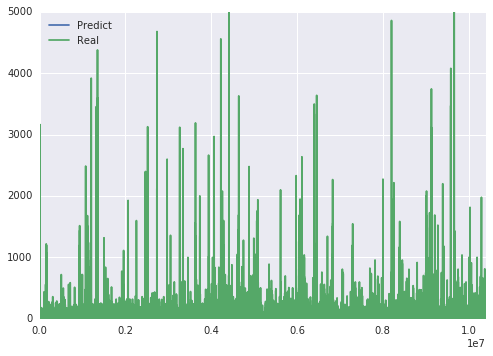

In [29]:
berker.plot()

In [23]:
np.mean(predictionsTest)

1.583607

In [24]:
np.mean(y_test)

1.6004740519086833

In [ ]:
print("Pickling sklearn API models")
# must open in binary format to pickle
pickle.dump(xgb_model, open("best_boston.pkl", "wb"))